# 0. Librairies

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Option de lecture d’affichage
pd.set_option('display.max_columns', 50)
sns.set(style="whitegrid")

# 1. Chargement des données

In [5]:
# Installation de l'API Kaggle

!pip install kaggle


   -------------------- ------------------- 4/8 [protobuf]
   -------------------- ------------------- 4/8 [protobuf]
   -------------------- ------------------- 4/8 [protobuf]
   ------------------------- -------------- 5/8 [bleach]
   ------------------------- -------------- 5/8 [bleach]
   ------------------------------ --------- 6/8 [python-dateutil]
   ----------------------------------- ---- 7/8 [kaggle]
   ----------------------------------- ---- 7/8 [kaggle]
   ----------------------------------- ---- 7/8 [kaggle]
   ----------------------------------- ---- 7/8 [kaggle]
   ----------------------------------- ---- 7/8 [kaggle]
   ---------------------------------------- 8/8 [kaggle]



In [7]:
# Téléchargement du dataset

!kaggle datasets download -d danofer/compass

Dataset URL: https://www.kaggle.com/datasets/danofer/compass
License(s): DbCL-1.0




  0%|          | 0.00/2.72M [00:00<?, ?B/s]
100%|##########| 2.72M/2.72M [00:00<00:00, 639MB/s]


In [8]:
# Extraction du fichier compass.zip

import zipfile

with zipfile.ZipFile("compass.zip", "r") as zip_ref:
    zip_ref.extractall("data")

In [9]:
# Affichage du contenu de compass

import os

for root, dirs, files in os.walk('data'):
    level = root.replace('data', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

data/
  compas-scores-raw.csv
  cox-violent-parsed.csv
  cox-violent-parsed_filt.csv
  propublicaCompassRecividism_data_fairml.csv/
    ._propublica_data_for_fairml.csv
    propublica_data_for_fairml.csv


**Contenu des fichiers :**
- *compas-scores-raw.csv :* données brutes de COMPAS, informations individuelles sur chaque personne accusée (âge, genre, ethnicité, délit, score COMPAS, arrestations, condamnations, résultat réel concernant la récidive;
  
- *cox-violent-parsed.csv :* sous-ensemble épuré des données brutes; cas de récidives pour infractions violentes; principalement pour les individus utilisés par ProPublica pour analyser la prédiction de la violence; colonnes relatives aux scores COMPAS, résultats de récidive, autres variables démographiques;

- *cox-violent-parsed_filt.csv :* filtres des individus de *cox-violent-parsed.csv* en enlevant les entrées incomplètes, incohérentes, ou les cas spécifiques exclus par ProPublica;


- *propublica_data_for_fairml.csv :* compilation et nettoyage par l’équipe de ProPublica pour leurs travaux sur FairML, une version formatée pour être compatible avec certains outils d’analyse d’équité algorithmique; les colonnes incluent les variables sociodémographiques, les résultats de récidive, les scores, etc., parfois renommées/préparées spécifiquement pour ces méthodes;


- *._propublica_data_for_fairml.csv :* fichier système caché (généré parfois sur MacOS ou lors de copies), à ignorer : il ne contient pas de données exploitables.

In [46]:
# Chargement des données dans des objets DataFrame

raw = pd.read_csv("data/compas-scores-raw.csv")
cv_parsed = pd.read_csv("data/cox-violent-parsed.csv")
cv_filt = pd.read_csv("data/cox-violent-parsed_filt.csv")
pp_fairml = pd.read_csv("data/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv")

# 2. Analyse Exploratoire

In [47]:
# 2.1. Vue globale des données

for name, df in zip(['raw', 'cv_parsed', 'cv_filt', 'pp_fairml'], [raw, cv_parsed, cv_filt, pp_fairml]):
    print(f"{name}: {df.shape[0]} lignes, {df.shape[1]} colonnes")
    display(df.head(5))

raw: 60843 lignes, 28 colonnes


Person_ID  AssessmentID  Case_ID Agency_Text LastName FirstName MiddleName  \
0      50844         57167    51950    PRETRIAL   Fisher     Kevin        NaN   
1      50844         57167    51950    PRETRIAL   Fisher     Kevin        NaN   
2      50844         57167    51950    PRETRIAL   Fisher     Kevin        NaN   
3      50848         57174    51956    PRETRIAL  KENDALL     KEVIN        NaN   
4      50848         57174    51956    PRETRIAL  KENDALL     KEVIN        NaN   

  Sex_Code_Text Ethnic_Code_Text DateOfBirth  ScaleSet_ID            ScaleSet  \
0          Male        Caucasian    12/05/92           22  Risk and Prescreen   
1          Male        Caucasian    12/05/92           22  Risk and Prescreen   
2          Male        Caucasian    12/05/92           22  Risk and Prescreen   
3          Male        Caucasian    09/16/84           22  Risk and Prescreen   
4          Male        Caucasian    09/16/84           22  Risk and Prescreen   

  AssessmentReason Language LegalStatus CustodyStatus MaritalStatus  \
0           Intake  English    Pretrial   Jail Inmate        Single   
1           Intake  English    Pretrial   Jail Inmate        Single   
2           Intake  English    Pretrial   Jail Inmate        Single   
3           Intake  English    Pretrial   Jail Inmate       Married   
4           Intake  English    Pretrial   Jail Inmate       Married   

  Screening_Date  RecSupervisionLevel RecSupervisionLevelText  Scale_ID  \
0    1/1/13 0:00                    1                     Low         7   
1    1/1/13 0:00                    1                     Low         8   
2    1/1/13 0:00                    1                     Low        18   
3    1/1/13 0:00                    1                     Low         7   
4    1/1/13 0:00                    1                     Low         8   

                 DisplayText  RawScore  DecileScore ScoreText AssessmentType  \
0           Risk of Violence     -2.08            4       Low            New   
1         Risk of Recidivism     -1.06            2       Low            New   
2  Risk of Failure to Appear     15.00            1       Low            New   
3           Risk of Violence     -2.84            2       Low            New   
4         Risk of Recidivism     -1.50            1       Low            New   

   IsCompleted  IsDeleted  
0            1          0  
1            1          0  
2            1          0  
3            1          0  
4            1          0

cv_parsed: 18316 lignes, 52 colonnes


id              name    first       last compas_screening_date   sex  \
0  1.0  miguel hernandez   miguel  hernandez            14/08/2013  Male   
1  2.0  miguel hernandez   miguel  hernandez            14/08/2013  Male   
2  3.0      michael ryan  michael       ryan            31/12/2014  Male   
3  4.0       kevon dixon    kevon      dixon            27/01/2013  Male   
4  5.0          ed philo       ed      philo            14/04/2013  Male   

          dob  age          age_cat              race  juv_fel_count  \
0  18/04/1947   69  Greater than 45             Other              0   
1  18/04/1947   69  Greater than 45             Other              0   
2  06/02/1985   31          25 - 45         Caucasian              0   
3  22/01/1982   34          25 - 45  African-American              0   
4  14/05/1991   24     Less than 25  African-American              0   

   decile_score  juv_misd_count  juv_other_count  priors_count  \
0             1               0                0             0   
1             1               0                0             0   
2             5               0                0             0   
3             3               0                0             0   
4             4               0                1             4   

   days_b_screening_arrest        c_jail_in       c_jail_out  c_case_number  \
0                     -1.0  13/08/2013 6:03  14/08/2013 5:41  13011352CF10A   
1                     -1.0  13/08/2013 6:03  14/08/2013 5:41  13011352CF10A   
2                      NaN              NaN              NaN            NaN   
3                     -1.0  26/01/2013 3:45  05/02/2013 5:36  13001275CF10A   
4                     -1.0  13/04/2013 4:58  14/04/2013 7:02  13005330CF10A   

  c_offense_date c_arrest_date  c_days_from_compas c_charge_degree  \
0     13/08/2013           NaN                 1.0            (F3)   
1     13/08/2013           NaN                 1.0            (F3)   
2            NaN           NaN                 NaN             NaN   
3     26/01/2013           NaN                 1.0            (F3)   
4     13/04/2013           NaN                 1.0            (F3)   

                    c_charge_desc  is_recid  ... r_days_from_arrest  \
0    Aggravated Assault w/Firearm         0  ...                NaN   
1    Aggravated Assault w/Firearm         0  ...                NaN   
2                             NaN        -1  ...                NaN   
3  Felony Battery w/Prior Convict         1  ...                NaN   
4           Possession of Cocaine         1  ...                0.0   

  r_offense_date                r_charge_desc   r_jail_in  r_jail_out  \
0            NaN                          NaN         NaN         NaN   
1            NaN                          NaN         NaN         NaN   
2            NaN                          NaN         NaN         NaN   
3     05/07/2013  Felony Battery (Dom Strang)         NaN         NaN   
4     16/06/2013  Driving Under The Influence  16/06/2013  16/06/2013   

  violent_recid is_violent_recid  vr_case_number  vr_charge_degree  \
0           NaN                0             NaN               NaN   
1           NaN                0             NaN               NaN   
2           NaN                0             NaN               NaN   
3           NaN                1   13009779CF10A              (F3)   
4           NaN                0             NaN               NaN   

  vr_offense_date               vr_charge_desc  type_of_assessment  \
0             NaN                          NaN  Risk of Recidivism   
1             NaN                          NaN  Risk of Recidivism   
2             NaN                          NaN  Risk of Recidivism   
3      05/07/2013  Felony Battery (Dom Strang)  Risk of Recidivism   
4             NaN                          NaN  Risk of Recidivism   

  decile_score.1 score_text  screening_date v_type_of_assessment  \
0              1        Low      14/08/2013  

cv_filt: 18316 lignes, 40 colonnes


id              name    first       last   sex         dob  age  \
0  1.0  miguel hernandez   miguel  hernandez  Male  18/04/1947   69   
1  2.0  miguel hernandez   miguel  hernandez  Male  18/04/1947   69   
2  3.0      michael ryan  michael       ryan  Male  06/02/1985   31   
3  4.0       kevon dixon    kevon      dixon  Male  22/01/1982   34   
4  5.0          ed philo       ed      philo  Male  14/05/1991   24   

           age_cat              race  juv_fel_count  decile_score  \
0  Greater than 45             Other              0             1   
1  Greater than 45             Other              0             1   
2          25 - 45         Caucasian              0             5   
3          25 - 45  African-American              0             3   
4     Less than 25  African-American              0             4   

   juv_misd_count  juv_other_count  priors_count  days_b_screening_arrest  \
0               0                0             0                     -1.0   
1               0                0             0                     -1.0   
2               0                0             0                      NaN   
3               0                0             0                     -1.0   
4               0                1             4                     -1.0   

         c_jail_in       c_jail_out  c_days_from_compas c_charge_degree  \
0  13/08/2013 6:03  14/08/2013 5:41                 1.0            (F3)   
1  13/08/2013 6:03  14/08/2013 5:41                 1.0            (F3)   
2              NaN              NaN                 NaN             NaN   
3  26/01/2013 3:45  05/02/2013 5:36                 1.0            (F3)   
4  13/04/2013 4:58  14/04/2013 7:02                 1.0            (F3)   

                    c_charge_desc  is_recid r_charge_degree  \
0    Aggravated Assault w/Firearm         0             NaN   
1    Aggravated Assault w/Firearm         0             NaN   
2                             NaN        -1             NaN   
3  Felony Battery w/Prior Convict         1            (F3)   
4           Possession of Cocaine         1            (M1)   

   r_days_from_arrest r_offense_date                r_charge_desc   r_jail_in  \
0                 NaN            NaN                          NaN         NaN   
1                 NaN            NaN                          NaN         NaN   
2                 NaN            NaN                          NaN         NaN   
3                 NaN     05/07/2013  Felony Battery (Dom Strang)         NaN   
4                 0.0     16/06/2013  Driving Under The Influence  16/06/2013   

   violent_recid  is_violent_recid vr_charge_degree vr_offense_date  \
0            NaN                 0              NaN             NaN   
1            NaN                 0              NaN             NaN   
2            NaN                 0              NaN             NaN   
3            NaN                 1             (F3)      05/07/2013   
4            NaN                 0              NaN             NaN   

                vr_charge_desc  type_of_assessment  decile_score.1 score_text  \
0                          NaN  Risk of Recidivism               1        Low   
1                          NaN  Risk of Recidivism               1        Low   
2                          NaN  Risk of Recidivism               5     Medium   
3  Felony Battery (Dom Strang)  Risk of Recidivism               3        Low   
4                          NaN  Risk of Recidivism               4        Low   

  screening_date v_type_of_assessment  v_decile_score v_score_text  \
0     14/08/2013     Risk of Violence               1          Low   
1     14/08/2013     Risk of Violence               1          Low   
2     31/12/2014     Risk of Violence               2          Low   
3     27/01/2013     Risk of Violence               1          Low   
4     14/04/2013     Risk of Violence               3          Low   

   priors_count.1  event  
0               0   

pp_fairml: 6172 lignes, 12 colonnes


Two_yr_Recidivism  Number_of_Priors  score_factor  Age_Above_FourtyFive  \
0                  0                 0             0                     1   
1                  1                 0             0                     0   
2                  1                 4             0                     0   
3                  0                 0             0                     0   
4                  1                14             1                     0   

   Age_Below_TwentyFive  African_American  Asian  Hispanic  Native_American  \
0                     0                 0      0         0                0   
1                     0                 1      0         0                0   
2                     1                 1      0         0                0   
3                     0                 0      0         0                0   
4                     0                 0      0         0                0   

   Other  Female  Misdemeanor  
0      1       0            0  
1      0       0            0  
2      0       0            0  
3      1       0            1  
4      0       0            0

In [48]:
# 2.2. Colonnes, types de données et valeurs manquantes

for name, df in zip(['raw', 'cv_filt', 'pp_fairml'], [raw, cv_filt, pp_fairml]):
    print(f"--- DataFrame : {name} ---")
    # affichage des colonnes et de leur type
    print("Colonnes et types:")
    print(df.dtypes)
    # calcul du nombre de valeurs manquantes par colonne
    print("\nNombre de valeurs manquantes par colonne:")
    print(df.isna().sum())
    print("\n")

--- DataFrame : raw ---
Colonnes et types:
Person_ID                    int64
AssessmentID                 int64
Case_ID                      int64
Agency_Text                 object
LastName                    object
FirstName                   object
MiddleName                  object
Sex_Code_Text               object
Ethnic_Code_Text            object
DateOfBirth                 object
ScaleSet_ID                  int64
ScaleSet                    object
AssessmentReason            object
Language                    object
LegalStatus                 object
CustodyStatus               object
MaritalStatus               object
Screening_Date              object
RecSupervisionLevel          int64
RecSupervisionLevelText     object
Scale_ID                     int64
DisplayText                 object
RawScore                   float64
DecileScore                  int64
ScoreText                   object
AssessmentType              object
IsCompleted                  int64
IsDeleted   

In [49]:
# 2.3. Conversion des colonnes dates du type obejct vers le type datetime

import pandas as pd

# dans raw
raw['DateOfBirth'] = pd.to_datetime(raw['DateOfBirth'], format='%d/%m/%y', errors='coerce', dayfirst=True)
# %y = année sur 2 chiffres, format '12/05/92'

raw['Screening_Date'] = pd.to_datetime(raw['Screening_Date'], format='%d/%m/%y %H:%M', errors='coerce', dayfirst=True)
# format '1/1/13 0:00', attention jour et mois sans 0 devant

# dans cv_filt

# dob en format jour/mois/année 4 chiffres :
cv_filt['dob'] = pd.to_datetime(cv_filt['dob'], format='%d/%m/%Y', errors='coerce', dayfirst=True)

# c_jail_in et c_jail_out en format complet avec heure minutes :
cv_filt['c_jail_in'] = pd.to_datetime(cv_filt['c_jail_in'], format='%d/%m/%Y %H:%M', errors='coerce', dayfirst=True)
cv_filt['c_jail_out'] = pd.to_datetime(cv_filt['c_jail_out'], format='%d/%m/%Y %H:%M', errors='coerce', dayfirst=True)

# screening_date, r_offense_date, vr_offense_date en format jour/mois/année simple :
for col in ['screening_date', 'r_offense_date', 'vr_offense_date']:
    cv_filt[col] = pd.to_datetime(cv_filt[col], format='%d/%m/%Y', errors='coerce', dayfirst=True)

In [40]:
# 2.4. Statistiques descriptives

In [50]:
# 2.4.1. raw

## a. Identifiants
id_cols = ['Person_ID', 'AssessmentID', 'Case_ID', 'ScaleSet_ID', 'Scale_ID']
for col in id_cols:
    unique_vals = raw[col].nunique()
    print(f"{col}: {unique_vals} valeurs uniques sur {len(raw)} lignes")

## b. Scores et variables numériques continues / ordinales
num_score_cols = ['RawScore', 'DecileScore', 'RecSupervisionLevel']
print(raw[num_score_cols].describe())

## c. Flags binaires
bin_cols = ['IsCompleted', 'IsDeleted']
for col in bin_cols:
    freq = raw[col].value_counts(normalize=True, dropna=False)
    print(f"\nDistribution de {col}:")
    display(freq.to_frame('freq'))

## d. Variables catégorielles textuelles à faible cardinalité
cat_cols = ['Agency_Text', 'Sex_Code_Text', 'Ethnic_Code_Text', 'ScaleSet', 'AssessmentReason', 
            'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 
            'RecSupervisionLevelText', 'ScoreText', 'AssessmentType']

for col in cat_cols:
    print(f"\nModalités de {col} (effectifs et fréquences):")
    display(raw[col].value_counts(dropna=False, normalize=True).to_frame('freq'))

## e. Variables textuelles à forte cardinalité (noms etc.)
text_cols = ['LastName', 'FirstName', 'MiddleName', 'DisplayText']
for col in text_cols:
    unique = raw[col].nunique()
    n_missing = raw[col].isna().sum()
    print(f"{col}: {unique} valeurs uniques, {n_missing} valeurs manquantes - modalités typiques inutile pour stats numériques.")

# f. Colonnes dates
print("\nDates:")
print(f"DateOfBirth min: {raw['DateOfBirth'].min()}, max: {raw['DateOfBirth'].max()}, NaNs: {raw['DateOfBirth'].isna().sum()}")
print(f"Screening_Date min: {raw['Screening_Date'].min()}, max: {raw['Screening_Date'].max()}, NaNs: {raw['Screening_Date'].isna().sum()}")

# Feature engineering à partir des dates : âge à la date d’évaluation
raw['Age_at_Screening'] = (raw['Screening_Date'] - raw['DateOfBirth']).dt.days // 365
print("Âge moyen à l'évaluation : ", raw['Age_at_Screening'].mean())
print("Statistiques âge :")
print(raw['Age_at_Screening'].describe())

Person_ID: 18610 valeurs uniques sur 60843 lignes
AssessmentID: 20281 valeurs uniques sur 60843 lignes
Case_ID: 19530 valeurs uniques sur 60843 lignes
ScaleSet_ID: 2 valeurs uniques sur 60843 lignes
Scale_ID: 3 valeurs uniques sur 60843 lignes
           RawScore   DecileScore  RecSupervisionLevel
count  60843.000000  60843.000000         60843.000000
mean       5.081457      3.571701             1.630048
std       10.080518      2.617854             0.944220
min       -4.790000     -1.000000             1.000000
25%       -2.090000      1.000000             1.000000
50%       -0.710000      3.000000             1.000000
75%       14.000000      5.000000             2.000000
max       51.000000     10.000000             4.000000

Distribution de IsCompleted:


freq
IsCompleted      
1             1.0


Distribution de IsDeleted:


freq
IsDeleted      
0           1.0


Modalités de Agency_Text (effectifs et fréquences):


freq
Agency_Text             
PRETRIAL        0.675509
Probation       0.313200
DRRD            0.009270
Broward County  0.002022


Modalités de Sex_Code_Text (effectifs et fréquences):


freq
Sex_Code_Text          
Male           0.780928
Female         0.219072


Modalités de Ethnic_Code_Text (effectifs et fréquences):


freq
Ethnic_Code_Text          
African-American  0.444061
Caucasian         0.358020
Hispanic          0.143681
Other             0.042601
Asian             0.005325
Native American   0.003599
Arabic            0.001233
African-Am        0.000838
Oriental          0.000641


Modalités de ScaleSet (effectifs et fréquences):


freq
ScaleSet                    
Risk and Prescreen  0.963907
All Scales          0.036093


Modalités de AssessmentReason (effectifs et fréquences):


freq
AssessmentReason      
Intake             1.0


Modalités de Language (effectifs et fréquences):


freq
Language          
English   0.995858
Spanish   0.004142


Modalités de LegalStatus (effectifs et fréquences):


freq
LegalStatus                  
Pretrial             0.617622
Post Sentence        0.301317
Other                0.071594
Conditional Release  0.006903
Probation Violator   0.002071
Parole Violator      0.000296
Deferred Sentencing  0.000197


Modalités de CustodyStatus (effectifs et fréquences):


freq
CustodyStatus                
Jail Inmate          0.495193
Probation            0.377496
Pretrial Defendant   0.125635
Residential Program  0.001085
Parole               0.000345
Prison Inmate        0.000247


Modalités de MaritalStatus (effectifs et fréquences):


freq
MaritalStatus              
Single             0.741679
Married            0.134313
Divorced           0.063754
Separated          0.029634
Significant Other  0.020709
Widowed            0.006410
Unknown            0.003501


Modalités de RecSupervisionLevelText (effectifs et fréquences):


freq
RecSupervisionLevelText                     
Low                                 0.632316
Medium                              0.172181
Medium with Override Consideration  0.128643
High                                0.066861


Modalités de ScoreText (effectifs et fréquences):


freq
ScoreText          
Low        0.681870
Medium     0.205250
High       0.112141
NaN        0.000740


Modalités de AssessmentType (effectifs et fréquences):


freq
AssessmentType          
New             0.922686
Copy            0.077314

LastName: 10896 valeurs uniques, 0 valeurs manquantes - modalités typiques inutile pour stats numériques.
FirstName: 7225 valeurs uniques, 0 valeurs manquantes - modalités typiques inutile pour stats numériques.
MiddleName: 1870 valeurs uniques, 45219 valeurs manquantes - modalités typiques inutile pour stats numériques.
DisplayText: 3 valeurs uniques, 0 valeurs manquantes - modalités typiques inutile pour stats numériques.

Dates:
DateOfBirth min: 1969-01-01 00:00:00, max: 2068-12-11 00:00:00, NaNs: 36693
Screening_Date min: 2013-01-01 00:00:00, max: 2014-12-12 00:00:00, NaNs: 37155
Âge moyen à l'évaluation :  12.811135716545397
Statistiques âge :
count    9483.000000
mean       12.811136
std        31.481176
min       -56.000000
25%        19.000000
50%        25.000000
75%        32.000000
max        45.000000
Name: Age_at_Screening, dtype: float64


In [56]:
# Cas problèmatique de Age_at_Screening négatifs

raw.loc[raw['Age_at_Screening'] < 0, ['DateOfBirth', 'Screening_Date', 'Age_at_Screening']].head()

Empty DataFrame
Columns: [DateOfBirth, Screening_Date, Age_at_Screening]
Index: []

In [52]:
# Correction

import pandas as pd

import datetime
today = pd.Timestamp.today()

def fix_dob(date):
    if pd.isnull(date):
        return date
    # Si la date est dans le futur (après aujourd'hui), on corrige en soustrayant 100 ans
    if date > today:
        return date - pd.DateOffset(years=100)
    return date

raw['DateOfBirth'] = raw['DateOfBirth'].apply(fix_dob)

# Recalcul de l'âge
raw['Age_at_Screening'] = (raw['Screening_Date'] - raw['DateOfBirth']).dt.days // 365

# Vérification des âges encore négatifs (si besoin)
invalid_ages = raw.loc[raw['Age_at_Screening'] < 0, ['DateOfBirth', 'Screening_Date', 'Age_at_Screening']]
print(f"Nombre d'âges négatifs restants : {len(invalid_ages)}")
print(invalid_ages.head())

Nombre d'âges négatifs restants : 0
Empty DataFrame
Columns: [DateOfBirth, Screening_Date, Age_at_Screening]
Index: []


In [53]:
# Correction des -1 dans DecilScore: on les remplace par NaN

raw['DecileScore'] = raw['DecileScore'].replace(-1, np.nan)

In [54]:
# Regroupement de caégories dans Ethnic_Code_Text

def normalize_ethnicity(x):
    if x in ['African-Am']:
        return 'African-American'
    elif x in ['Oriental', 'Arabic']:
        return 'Other'
    else:
        return x
raw['Ethnic_Code_Text'] = raw['Ethnic_Code_Text'].apply(normalize_ethnicity)

In [55]:
# Suppression des NaN dans ScoreText

raw = raw.dropna(subset=['ScoreText'])

In [57]:
# Nouvelles statistiques pour raw

## a. Identifiants
id_cols = ['Person_ID', 'AssessmentID', 'Case_ID', 'ScaleSet_ID', 'Scale_ID']
for col in id_cols:
    unique_vals = raw[col].nunique()
    print(f"{col}: {unique_vals} valeurs uniques sur {len(raw)} lignes")

## b. Scores et variables numériques continues / ordinales
num_score_cols = ['RawScore', 'DecileScore', 'RecSupervisionLevel']
print(raw[num_score_cols].describe())

## c. Flags binaires
bin_cols = ['IsCompleted', 'IsDeleted']
for col in bin_cols:
    freq = raw[col].value_counts(normalize=True, dropna=False)
    print(f"\nDistribution de {col}:")
    display(freq.to_frame('freq'))

## d. Variables catégorielles textuelles à faible cardinalité
cat_cols = ['Agency_Text', 'Sex_Code_Text', 'Ethnic_Code_Text', 'ScaleSet', 'AssessmentReason', 
            'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 
            'RecSupervisionLevelText', 'ScoreText', 'AssessmentType']

for col in cat_cols:
    print(f"\nModalités de {col} (effectifs et fréquences):")
    display(raw[col].value_counts(dropna=False, normalize=True).to_frame('freq'))

## e. Variables textuelles à forte cardinalité (noms etc.)
text_cols = ['LastName', 'FirstName', 'MiddleName', 'DisplayText']
for col in text_cols:
    unique = raw[col].nunique()
    n_missing = raw[col].isna().sum()
    print(f"{col}: {unique} valeurs uniques, {n_missing} valeurs manquantes - modalités typiques inutile pour stats numériques.")

# f. Colonnes dates
print("\nDates:")
print(f"DateOfBirth min: {raw['DateOfBirth'].min()}, max: {raw['DateOfBirth'].max()}, NaNs: {raw['DateOfBirth'].isna().sum()}")
print(f"Screening_Date min: {raw['Screening_Date'].min()}, max: {raw['Screening_Date'].max()}, NaNs: {raw['Screening_Date'].isna().sum()}")

# Feature engineering à partir des dates : âge à la date d’évaluation
raw['Age_at_Screening'] = (raw['Screening_Date'] - raw['DateOfBirth']).dt.days // 365
print("Âge moyen à l'évaluation : ", raw['Age_at_Screening'].mean())
print("Statistiques âge :")
print(raw['Age_at_Screening'].describe())

Person_ID: 18610 valeurs uniques sur 60798 lignes
AssessmentID: 20281 valeurs uniques sur 60798 lignes
Case_ID: 19530 valeurs uniques sur 60798 lignes
ScaleSet_ID: 2 valeurs uniques sur 60798 lignes
Scale_ID: 3 valeurs uniques sur 60798 lignes
           RawScore   DecileScore  RecSupervisionLevel
count  60798.000000  60798.000000         60798.000000
mean       5.085958      3.575085             1.630399
std       10.082890      2.615865             0.944412
min       -4.790000      1.000000             1.000000
25%       -2.090000      1.000000             1.000000
50%       -0.700000      3.000000             1.000000
75%       14.000000      5.000000             2.000000
max       51.000000     10.000000             4.000000

Distribution de IsCompleted:


freq
IsCompleted      
1             1.0


Distribution de IsDeleted:


freq
IsDeleted      
0           1.0


Modalités de Agency_Text (effectifs et fréquences):


freq
Agency_Text             
PRETRIAL        0.675631
Probation       0.313070
DRRD            0.009277
Broward County  0.002023


Modalités de Sex_Code_Text (effectifs et fréquences):


freq
Sex_Code_Text         
Male           0.78093
Female         0.21907


Modalités de Ethnic_Code_Text (effectifs et fréquences):


freq
Ethnic_Code_Text          
African-American  0.444965
Caucasian         0.357989
Hispanic          0.143640
Other             0.044475
Asian             0.005329
Native American   0.003602


Modalités de ScaleSet (effectifs et fréquences):


freq
ScaleSet                   
Risk and Prescreen  0.96388
All Scales          0.03612


Modalités de AssessmentReason (effectifs et fréquences):


freq
AssessmentReason      
Intake             1.0


Modalités de Language (effectifs et fréquences):


freq
Language          
English   0.995855
Spanish   0.004145


Modalités de LegalStatus (effectifs et fréquences):


freq
LegalStatus                  
Pretrial             0.617734
Post Sentence        0.301293
Other                0.071532
Conditional Release  0.006875
Probation Violator   0.002072
Parole Violator      0.000296
Deferred Sentencing  0.000197


Modalités de CustodyStatus (effectifs et fréquences):


freq
CustodyStatus                
Jail Inmate          0.495345
Probation            0.377348
Pretrial Defendant   0.125678
Residential Program  0.001036
Parole               0.000345
Prison Inmate        0.000247


Modalités de MaritalStatus (effectifs et fréquences):


freq
MaritalStatus              
Single             0.741718
Married            0.134264
Divorced           0.063769
Separated          0.029639
Significant Other  0.020691
Widowed            0.006415
Unknown            0.003503


Modalités de RecSupervisionLevelText (effectifs et fréquences):


freq
RecSupervisionLevelText                     
Low                                 0.632143
Medium                              0.172226
Medium with Override Consideration  0.128721
High                                0.066910


Modalités de ScoreText (effectifs et fréquences):


freq
ScoreText          
Low        0.682374
Medium     0.205401
High       0.112224


Modalités de AssessmentType (effectifs et fréquences):


freq
AssessmentType          
New             0.922662
Copy            0.077338

LastName: 10896 valeurs uniques, 0 valeurs manquantes - modalités typiques inutile pour stats numériques.
FirstName: 7225 valeurs uniques, 0 valeurs manquantes - modalités typiques inutile pour stats numériques.
MiddleName: 1870 valeurs uniques, 45183 valeurs manquantes - modalités typiques inutile pour stats numériques.
DisplayText: 3 valeurs uniques, 0 valeurs manquantes - modalités typiques inutile pour stats numériques.

Dates:
DateOfBirth min: 1933-07-03 00:00:00, max: 2018-04-11 00:00:00, NaNs: 36660
Screening_Date min: 2013-01-01 00:00:00, max: 2014-12-12 00:00:00, NaNs: 37134
Âge moyen à l'évaluation :  33.66972767574414
Statistiques âge :
count    9474.000000
mean       33.669728
std        12.128833
min        17.000000
25%        24.000000
50%        30.000000
75%        42.000000
max        79.000000
Name: Age_at_Screening, dtype: float64


In [58]:
# Variable indiquant l'info âge disponible
raw['Age_at_Screening_missing'] = raw['Age_at_Screening'].isna().astype(int)

'''# Traitement des NaN dans Age_at_Screening
age_mean = raw['Age_at_Screening'].mean()
raw['Age_at_Screening_filled'] = raw['Age_at_Screening'].fillna(age_mean)'''

"# Traitement des NaN dans Age_at_Screening\nage_mean = raw['Age_at_Screening'].mean()\nraw['Age_at_Screening_filled'] = raw['Age_at_Screening'].fillna(age_mean)"

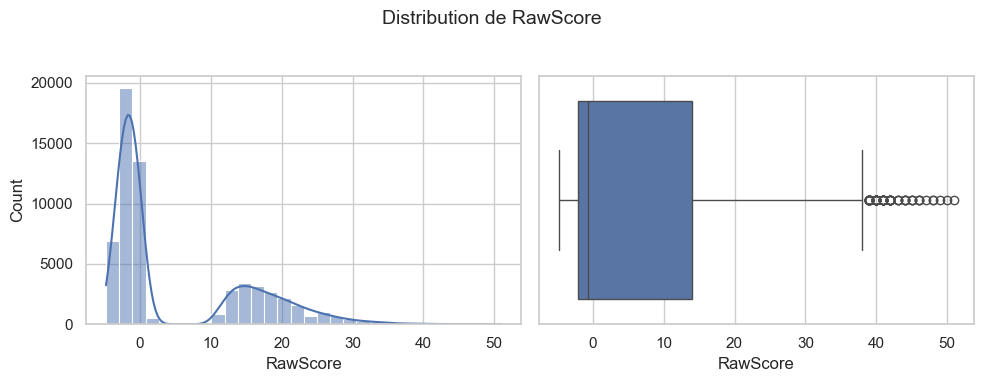

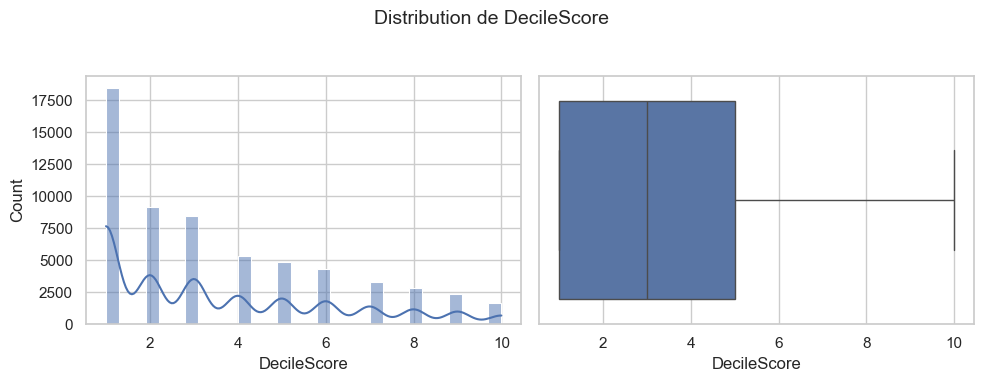

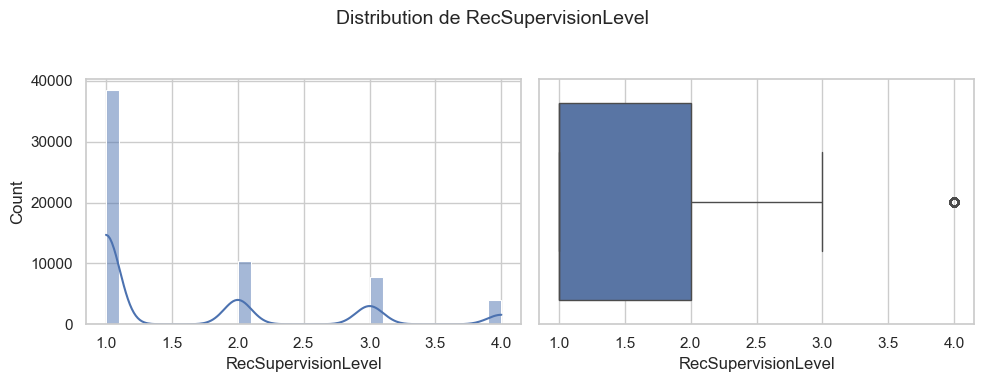

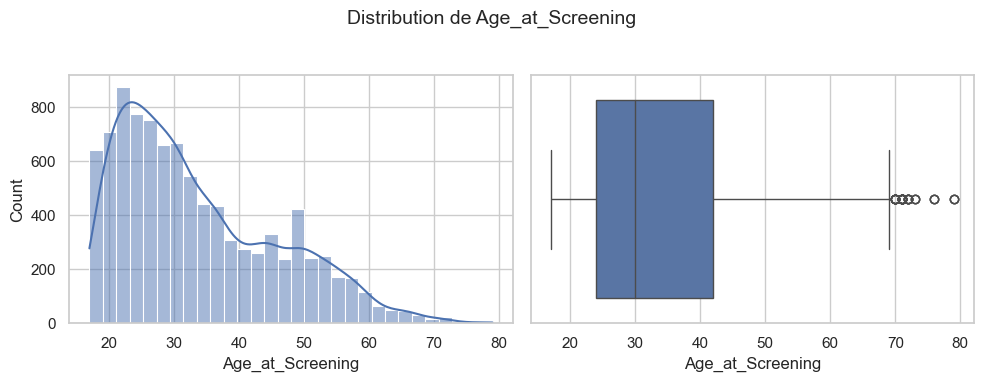

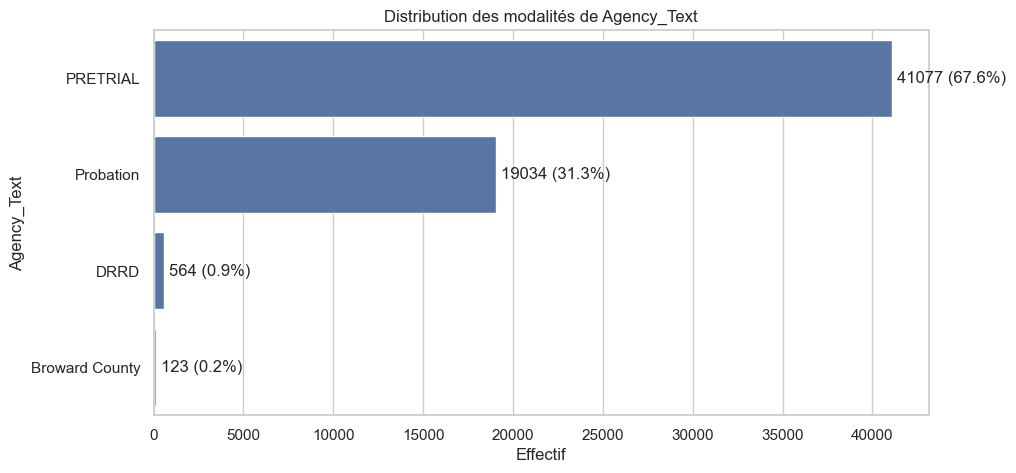

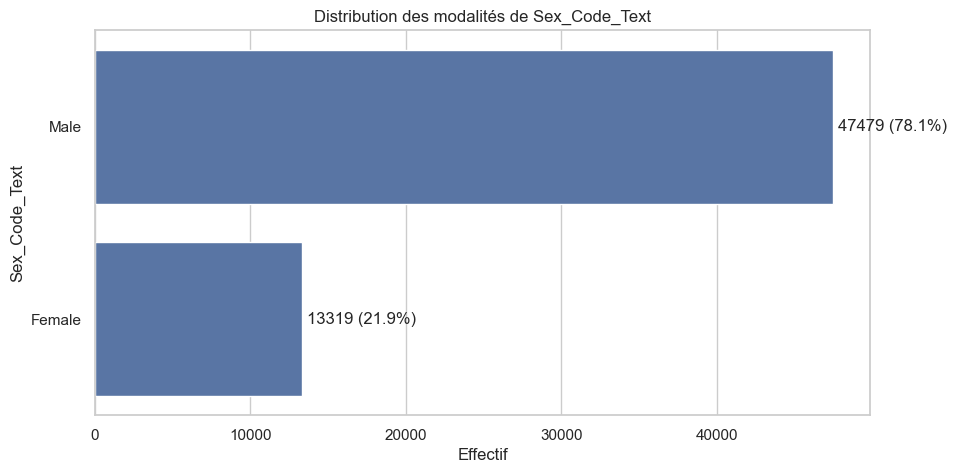

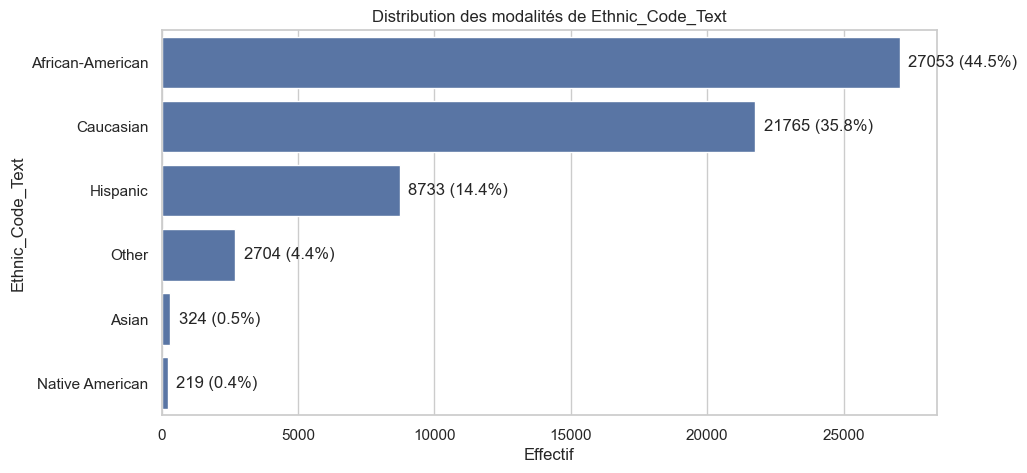

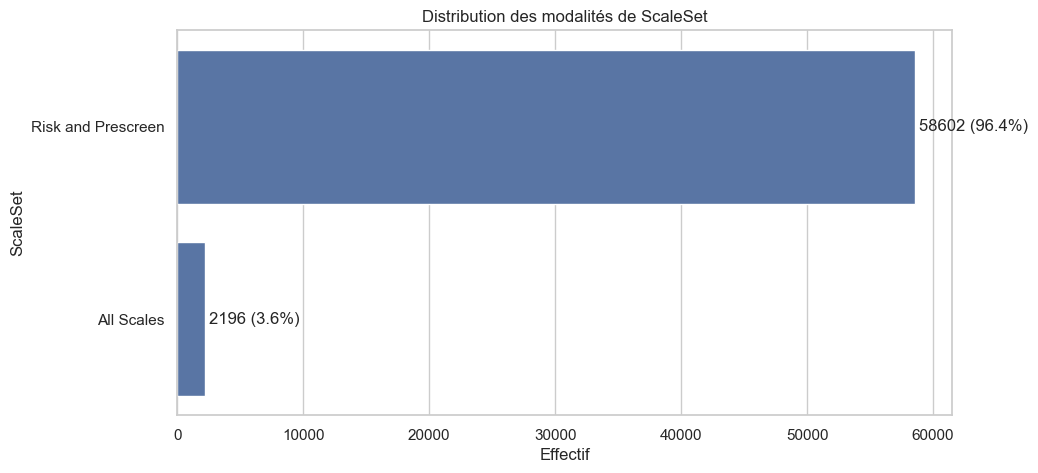

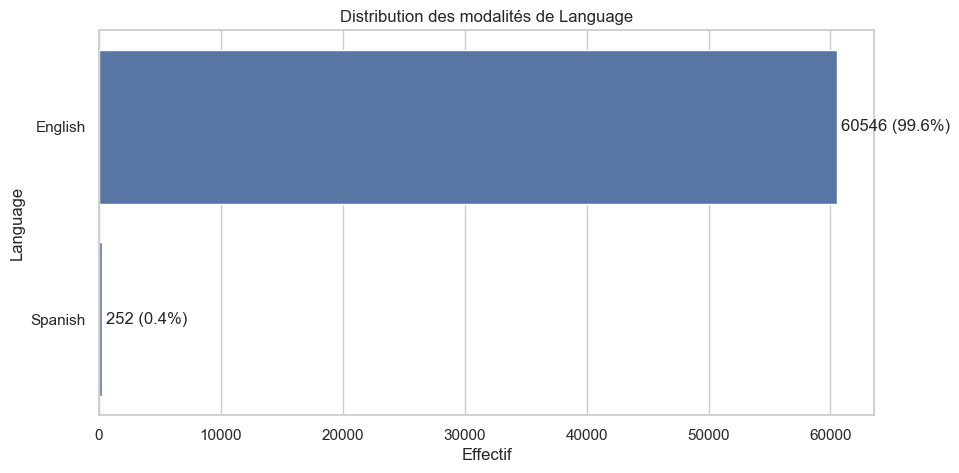

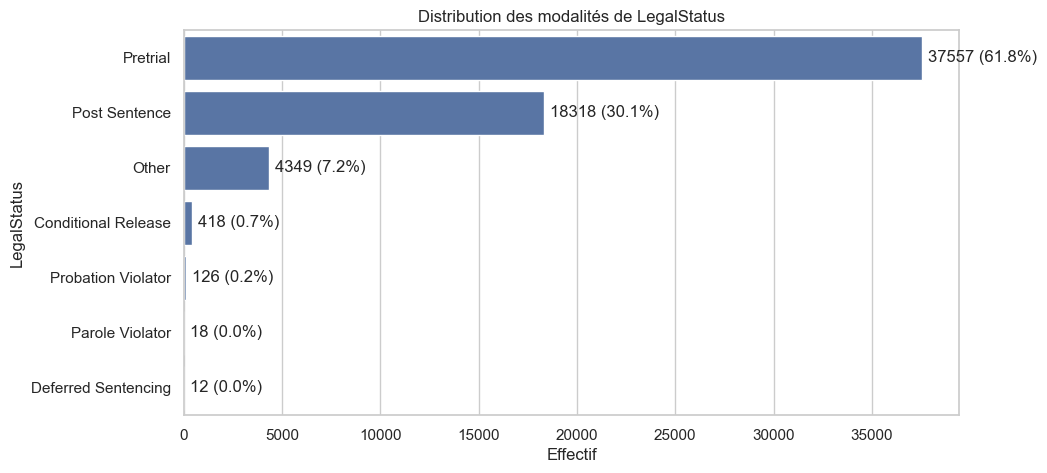

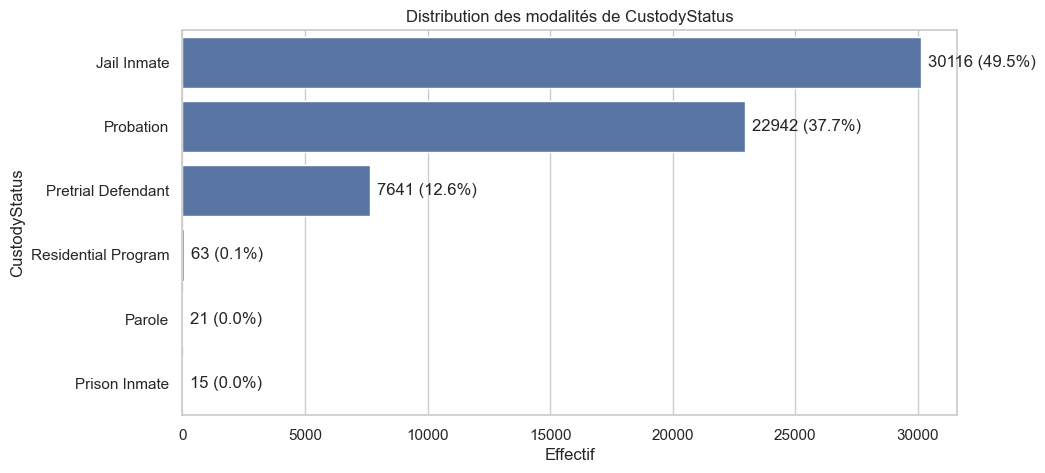

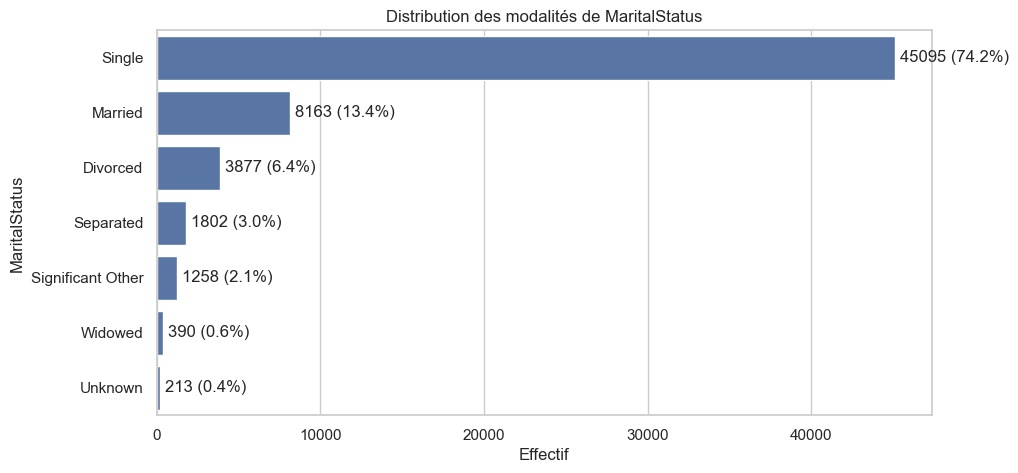

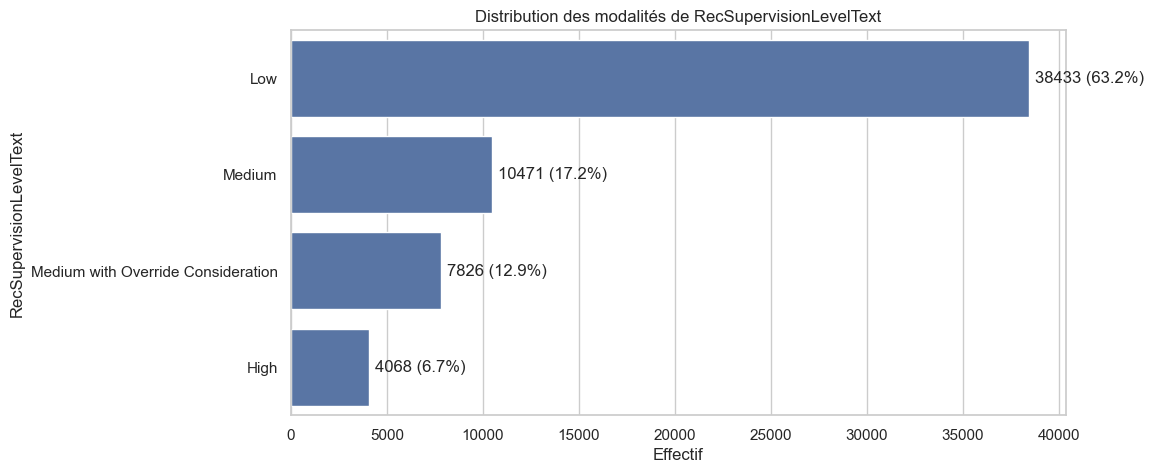

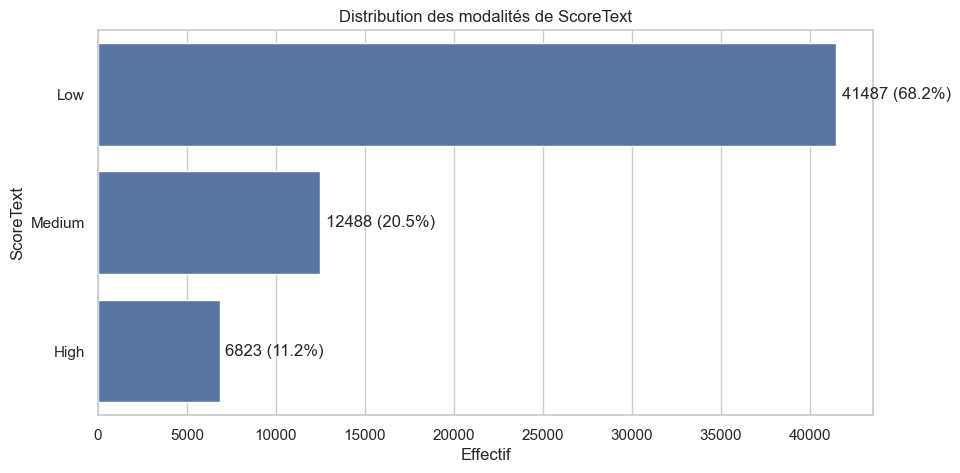

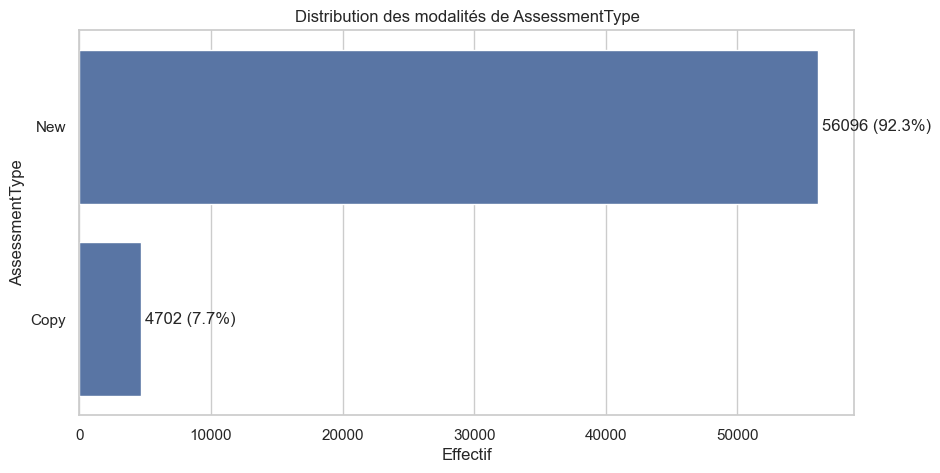

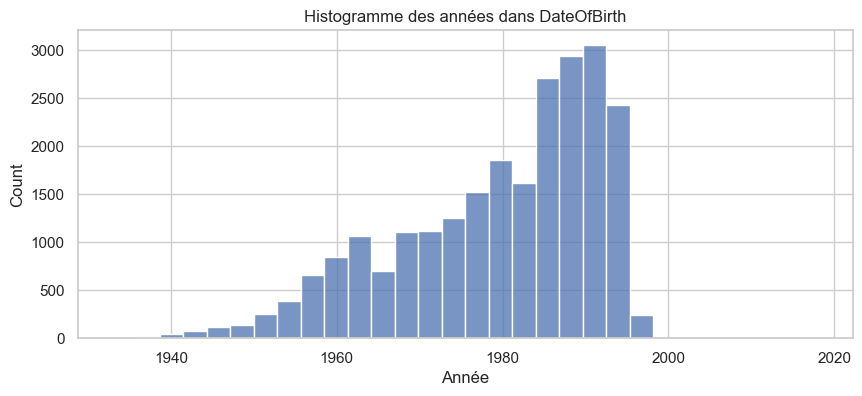

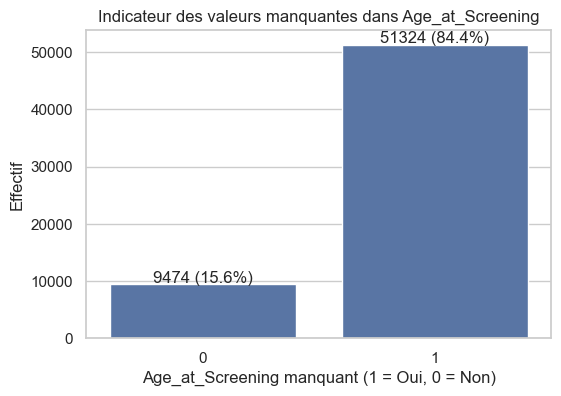

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Variables numériques continues / ordinales
num_cols = ['RawScore', 'DecileScore', 'RecSupervisionLevel', 'Age_at_Screening']

for col in num_cols:
    plt.figure(figsize=(10,4))
    plt.suptitle(f'Distribution de {col}', fontsize=14)
    
    # Histogramme
    plt.subplot(1,2,1)
    sns.histplot(raw[col].dropna(), bins=30, kde=True)
    plt.xlabel(col)
    
    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=raw[col])
    plt.xlabel(col)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Variables catégorielles à faible cardinalité (sans AssessmentReason)
cat_cols = ['Agency_Text', 'Sex_Code_Text', 'Ethnic_Code_Text', 'ScaleSet',
            'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
            'RecSupervisionLevelText', 'ScoreText', 'AssessmentType']

for col in cat_cols:
    plt.figure(figsize=(10,5))
    order = raw[col].value_counts().index
    # Retirer palette pour supprimer le warning
    ax = sns.countplot(data=raw, y=col, order=order)
    
    total = len(raw)
    for p in ax.patches:
        count = p.get_width()
        percentage = 100 * count / total
        ax.text(count + total*0.005, p.get_y() + p.get_height()/2,
                f'{int(count)} ({percentage:.1f}%)', va='center')
    plt.title(f"Distribution des modalités de {col}")
    plt.xlabel("Effectif")
    plt.ylabel(col)
    plt.show()

# Dates : on exclut 'Screening_Date' de l'histogramme des années (car tu souhaites ne pas l'afficher)
date_cols = ['DateOfBirth']  # uniquement DOB ici

for col in date_cols:
    plt.figure(figsize=(10,4))
    years = raw[col].dropna().dt.year
    sns.histplot(years, bins=30)
    plt.title(f'Histogramme des années dans {col}')
    plt.xlabel('Année')
    plt.show()

# Variable binaire Age_at_Screening_missing
plt.figure(figsize=(6,4))
sns.countplot(data=raw, x='Age_at_Screening_missing')
total = len(raw)
for p in plt.gca().patches:
    count = p.get_height()
    plt.text(p.get_x() + p.get_width()/2, count + total*0.005,
             f'{int(count)} ({100*count/total:.1f}%)', ha='center')
plt.title("Indicateur des valeurs manquantes dans Age_at_Screening")
plt.xlabel("Age_at_Screening manquant (1 = Oui, 0 = Non)")
plt.ylabel("Effectif")
plt.show()

In [61]:
# 2.4.2. cv_filt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

def analyze_cv_filt(df):
    print(f"DataFrame cv_filt: {df.shape[0]} lignes, {df.shape[1]} colonnes\n")
    
    # --- Identifiants et colonnes textuelles à forte cardinalité ---
    high_card_cols = ['id', 'name', 'first', 'last']
    for col in high_card_cols:
        if col in df.columns:
            unique_count = df[col].nunique(dropna=True)
            missing = df[col].isna().sum()
            print(f"{col}: {unique_count} valeurs uniques, {missing} valeurs manquantes")
    print("\n")

    # --- Variables catégorielles intéressantes ---
    cat_cols = ['sex', 'age_cat', 'race', 'c_charge_degree', 'r_charge_degree', 'vr_charge_degree',
                'type_of_assessment', 'score_text', 'v_type_of_assessment', 'v_score_text']
    for col in cat_cols:
        if col in df.columns:
            print(f"Modalités de {col} (effectifs et fréquences):")
            vc = df[col].value_counts(dropna=False)
            vcn = df[col].value_counts(normalize=True, dropna=False)
            display(pd.DataFrame({'count': vc, 'frequency': vcn}))
            # Graphique
            plt.figure(figsize=(8,4))
            order = vc.index
            ax = sns.countplot(data=df, x=col, order=order, palette="pastel")
            plt.title(f"Distribution des modalités de {col}")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()
            print("\n")

    # --- Variables numériques ---
    num_cols = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 
                'priors_count', 'priors_count.1', 'decile_score', 'decile_score.1',
                'v_decile_score', 'days_b_screening_arrest', 'c_days_from_compas',
                'r_days_from_arrest', 'violent_recid']
    existing_num_cols = [c for c in num_cols if c in df.columns]
    if existing_num_cols:
        print("Statistiques descriptives des variables numériques:")
        display(df[existing_num_cols].describe())
        # Visualisations simples
        for col in existing_num_cols:
            plt.figure(figsize=(10,4))
            plt.suptitle(f"Distribution de {col}", fontsize=14)
            plt.subplot(1,2,1)
            sns.histplot(df[col].dropna(), bins=30, kde=True)
            plt.xlabel(col)
            plt.subplot(1,2,2)
            sns.boxplot(x=df[col])
            plt.xlabel(col)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
        print("\n")

    # --- Variables binaires et cibles ---
    bin_cols = ['is_recid', 'is_violent_recid', 'event']
    for col in bin_cols:
        if col in df.columns:
            print(f"Distribution de {col}:")
            vc = df[col].value_counts(dropna=False)
            vcn = df[col].value_counts(normalize=True, dropna=False)
            display(pd.DataFrame({'count': vc, 'frequency': vcn}))
            plt.figure(figsize=(6,4))
            ax = sns.countplot(data=df, x=col, palette="Set2")
            total = len(df)
            for p in ax.patches:
                count = p.get_height()
                ax.text(p.get_x() + p.get_width()/2, count + total*0.005, f'{int(count)} ({100*count/total:.1f}%)', ha='center')
            plt.title(f"Distribution de {col}")
            plt.show()
            print("\n")

    # --- Colonnes dates ---
    date_cols = ['dob', 'screening_date', 'r_offense_date', 'vr_offense_date', 'c_jail_in', 'c_jail_out']
    for col in date_cols:
        if col in df.columns:
            valid_dates = df[col].dropna()
            print(f"Dates dans '{col}':")
            if len(valid_dates) > 0:
                print(f"min: {valid_dates.min()}, max: {valid_dates.max()}, NaNs: {df[col].isna().sum()}")
                # Histogramme des années
                years = valid_dates.dt.year
                plt.figure(figsize=(10,4))
                sns.histplot(years, bins=30, color='skyblue')
                plt.title(f"Distribution des années dans {col}")
                plt.xlabel('Année')
                plt.show()
            else:
                print("Aucune date valide.\n")

DataFrame cv_filt: 18316 lignes, 40 colonnes

id: 11001 valeurs uniques, 7315 valeurs manquantes
name: 10855 valeurs uniques, 0 valeurs manquantes
first: 3876 valeurs uniques, 0 valeurs manquantes
last: 5635 valeurs uniques, 0 valeurs manquantes


Modalités de sex (effectifs et fréquences):


count  frequency
sex                     
Male    14933   0.815298
Female   3383   0.184702

C:\Users\sasse\AppData\Local\Temp\ipykernel_11132\1517243264.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


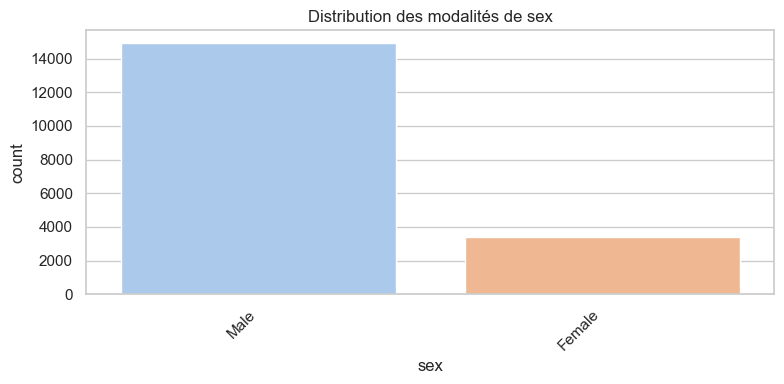



Modalités de age_cat (effectifs et fréquences):


count  frequency
age_cat                          
25 - 45          10372   0.566281
Less than 25      4283   0.233839
Greater than 45   3661   0.199880

C:\Users\sasse\AppData\Local\Temp\ipykernel_11132\1517243264.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


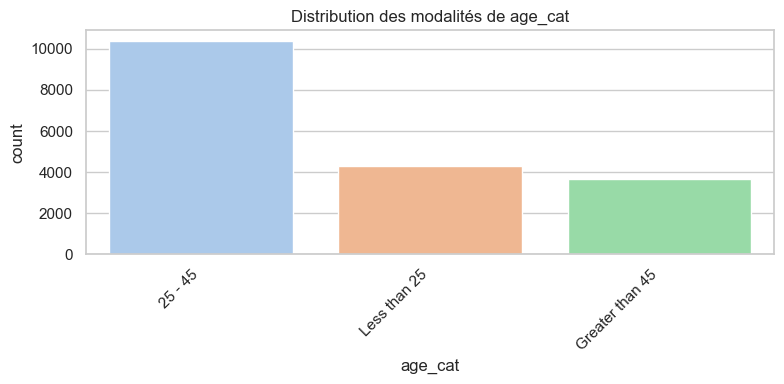



Modalités de race (effectifs et fréquences):


count  frequency
race                              
African-American   9791   0.534560
Caucasian          6086   0.332278
Hispanic           1451   0.079220
Other               860   0.046953
Asian                71   0.003876
Native American      57   0.003112

C:\Users\sasse\AppData\Local\Temp\ipykernel_11132\1517243264.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


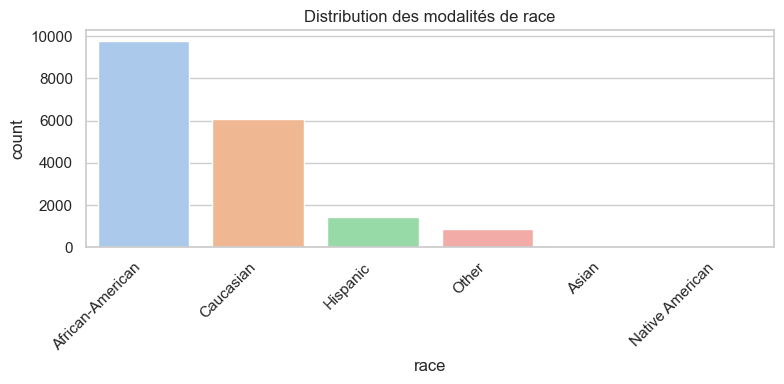



Modalités de c_charge_degree (effectifs et fréquences):


count  frequency
c_charge_degree                  
(F3)             10294   0.562022
(M1)              3681   0.200972
(F2)              1503   0.082059
(M2)              1283   0.070048
NaN                867   0.047336
(F1)               298   0.016270
(F7)               184   0.010046
(MO3)              154   0.008408
(NI0)               15   0.000819
(F6)                15   0.000819
(F5)                13   0.000710
(CO3)                6   0.000328
(X)                  1   0.000055
(CT)                 1   0.000055
(TCX)                1   0.000055

C:\Users\sasse\AppData\Local\Temp\ipykernel_11132\1517243264.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


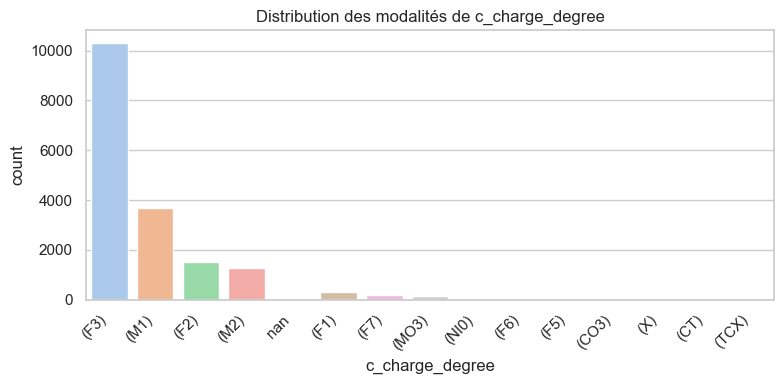



Modalités de r_charge_degree (effectifs et fréquences):


count  frequency
r_charge_degree                  
NaN               9899   0.540456
(M1)              2922   0.159533
(M2)              2590   0.141406
(F3)              2315   0.126392
(F2)               332   0.018126
(MO3)              133   0.007261
(F1)               103   0.005623
(CO3)               10   0.000546
(F7)                 8   0.000437
(F6)                 3   0.000164
(F5)                 1   0.000055

C:\Users\sasse\AppData\Local\Temp\ipykernel_11132\1517243264.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


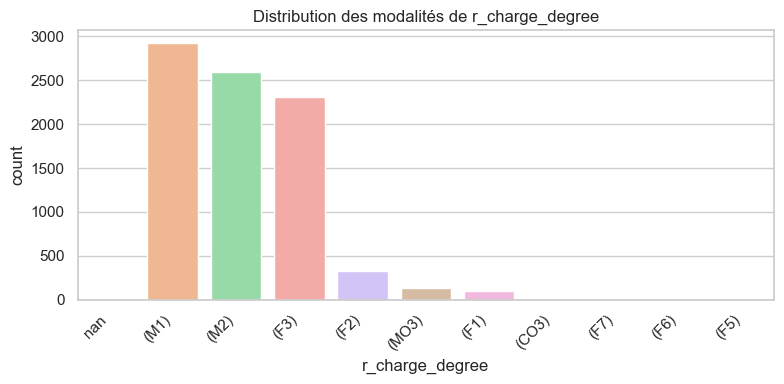



Modalités de vr_charge_degree (effectifs et fréquences):


count  frequency
vr_charge_degree                  
NaN               16977   0.926895
(M1)                550   0.030028
(F3)                374   0.020419
(F2)                276   0.015069
(F1)                 65   0.003549
(M2)                 40   0.002184
(F7)                 23   0.001256
(MO3)                 6   0.000328
(F6)                  4   0.000218
(F5)                  1   0.000055

C:\Users\sasse\AppData\Local\Temp\ipykernel_11132\1517243264.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


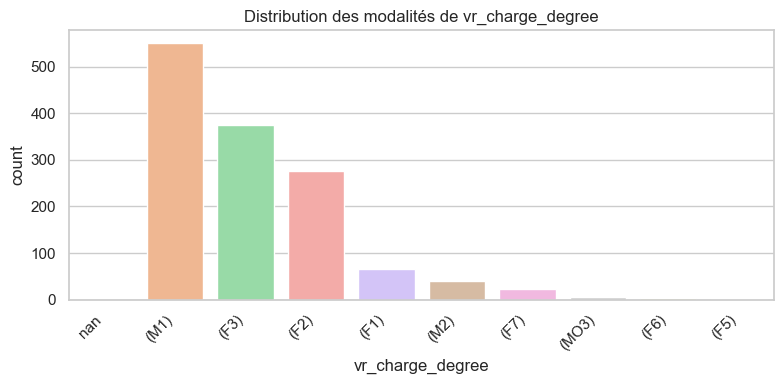



Modalités de type_of_assessment (effectifs et fréquences):


count  frequency
type_of_assessment                  
Risk of Recidivism  18316        1.0

C:\Users\sasse\AppData\Local\Temp\ipykernel_11132\1517243264.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


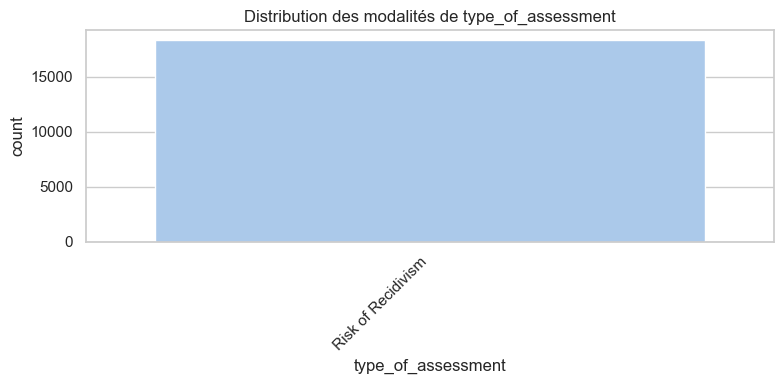



Modalités de score_text (effectifs et fréquences):


count  frequency
score_text                  
Low          8597   0.469371
Medium       5082   0.277462
High         4614   0.251911
NaN            23   0.001256

C:\Users\sasse\AppData\Local\Temp\ipykernel_11132\1517243264.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


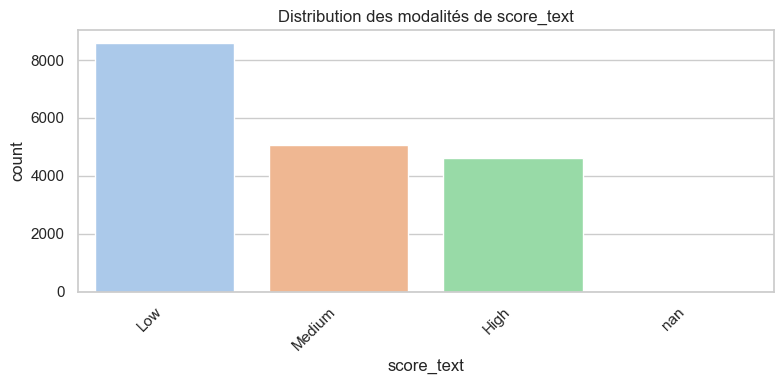



Modalités de v_type_of_assessment (effectifs et fréquences):


count  frequency
v_type_of_assessment                  
Risk of Violence      18316        1.0

C:\Users\sasse\AppData\Local\Temp\ipykernel_11132\1517243264.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


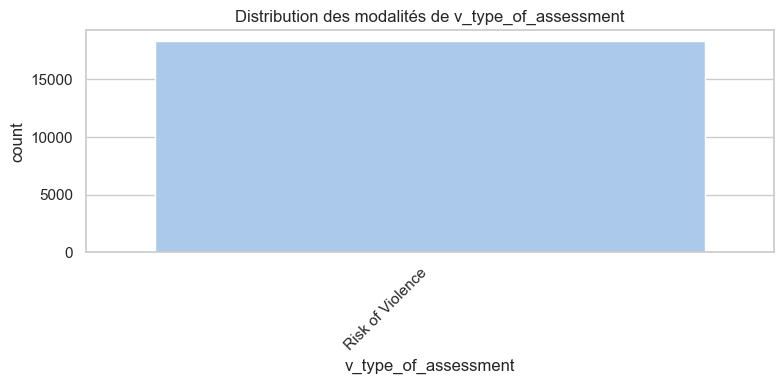



Modalités de v_score_text (effectifs et fréquences):


count  frequency
v_score_text                  
Low           11147   0.608594
Medium         4786   0.261302
High           2377   0.129777
NaN               6   0.000328

C:\Users\sasse\AppData\Local\Temp\ipykernel_11132\1517243264.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=col, order=order, palette="pastel")


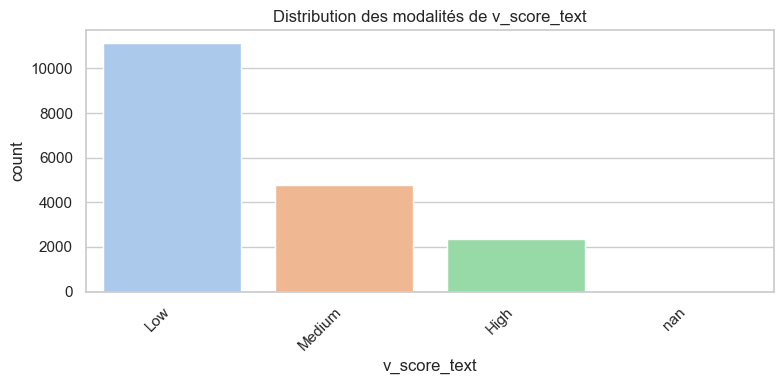



Statistiques descriptives des variables numériques:


age  juv_fel_count  juv_misd_count  juv_other_count  \
count  18316.000000   18316.000000    18316.000000     18316.000000   
mean      34.019273       0.076873        0.098439         0.124263   
std       11.667811       0.464272        0.517639         0.524537   
min       18.000000       0.000000        0.000000         0.000000   
25%       25.000000       0.000000        0.000000         0.000000   
50%       31.000000       0.000000        0.000000         0.000000   
75%       41.000000       0.000000        0.000000         0.000000   
max       96.000000      20.000000       13.000000        17.000000   

       priors_count  priors_count.1  decile_score  decile_score.1  \
count  18316.000000    18316.000000  18316.000000    18316.000000   
mean       3.913191        3.913191      4.997052        4.997052   
std        5.299864        5.299864      2.937569        2.937569   
min        0.000000        0.000000     -1.000000       -1.000000   
25%        0.000000        0.000000      2.000000        2.000000   
50%        2.000000        2.000000      5.000000        5.000000   
75%        5.000000        5.000000      8.000000        8.000000   
max       43.000000       43.000000     10.000000       10.000000   

       v_decile_score  days_b_screening_arrest  c_days_from_compas  \
count    18316.000000             17019.000000        17449.000000   
mean         4.022822                 4.302485           57.694596   
std          2.614189                81.159881          317.994694   
min         -1.000000              -597.000000            0.000000   
25%          2.000000                -1.000000            1.000000   
50%          4.000000                -1.000000            1.000000   
75%          6.000000                 0.000000            2.000000   
max         10.000000              1057.000000         9485.000000   

       r_days_from_arrest  violent_recid  
count         6359.000000            0.0  
mean            19.961629            NaN  
std             74.139695            NaN  
min             -1.000000            NaN  
25%              0.000000            NaN  
50%              0.000000            NaN  
75%              1.000000            NaN  
max            993.000000            NaN

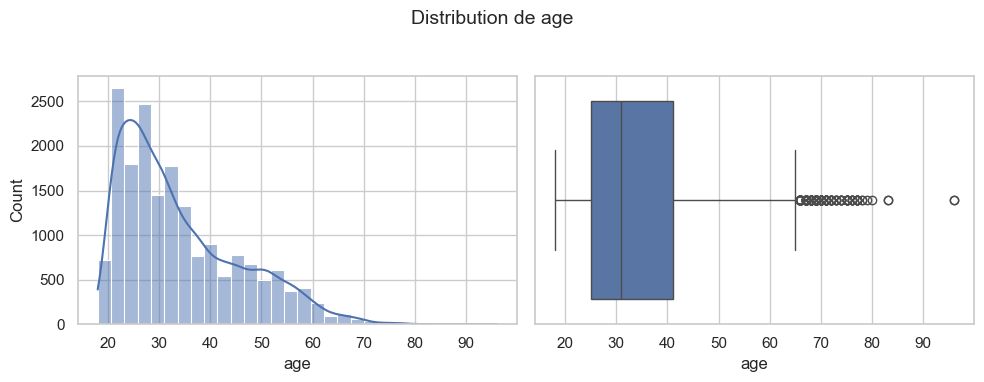

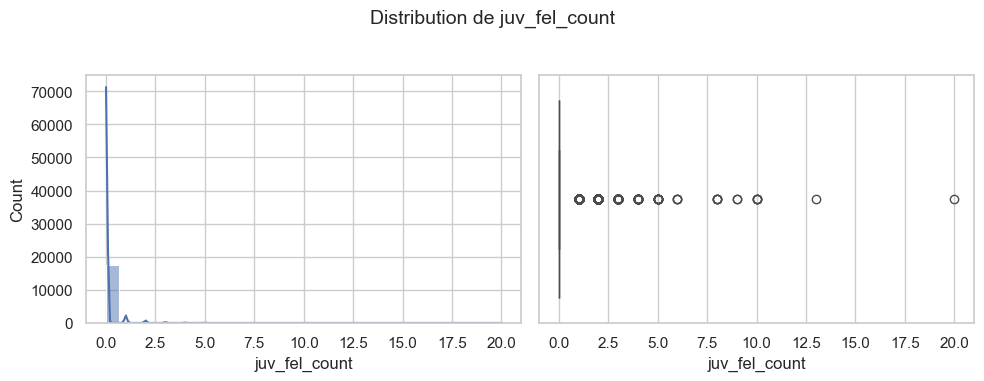

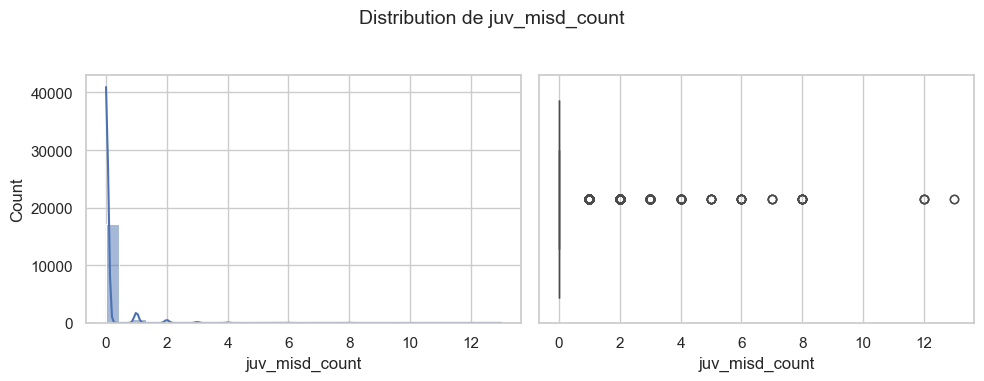

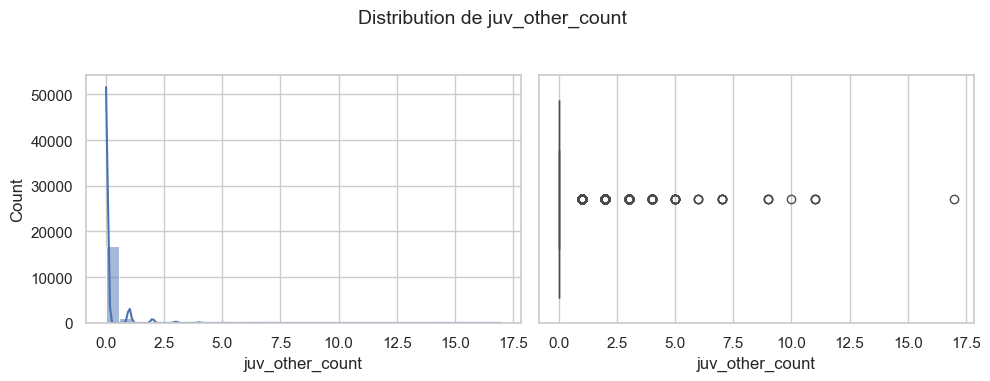

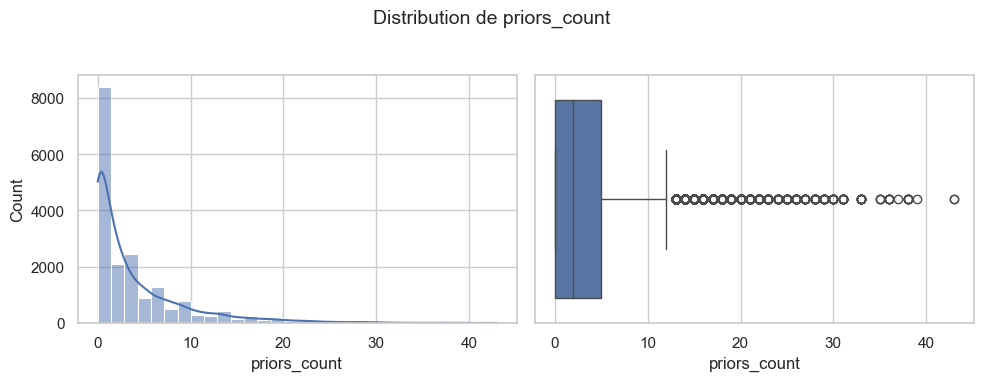

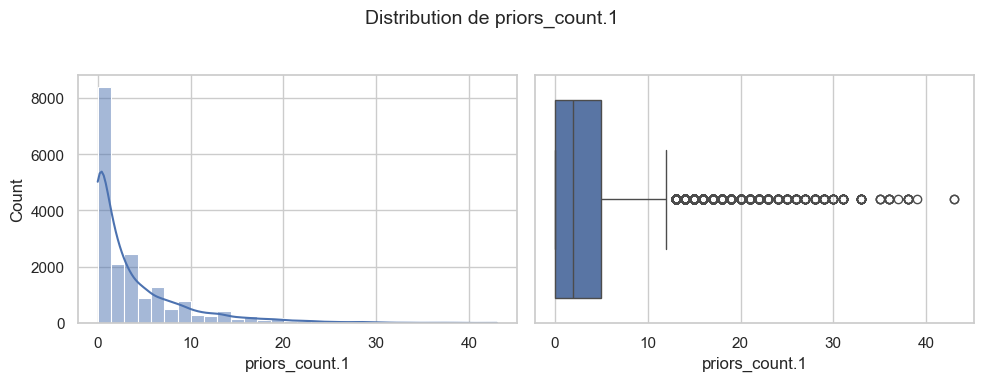

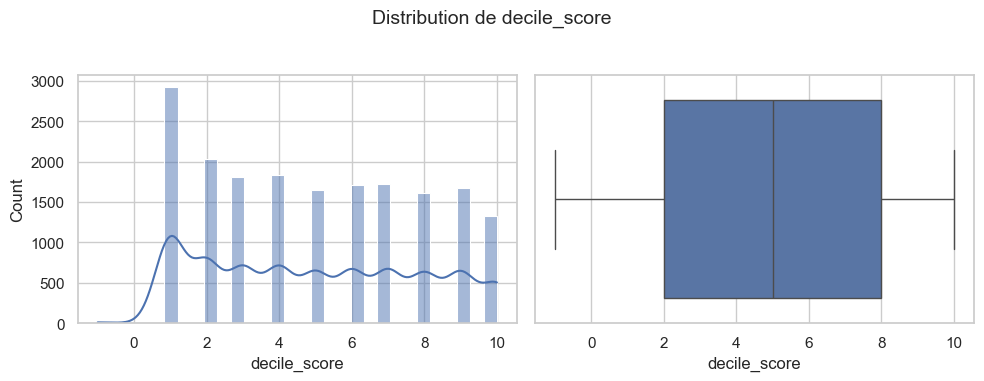

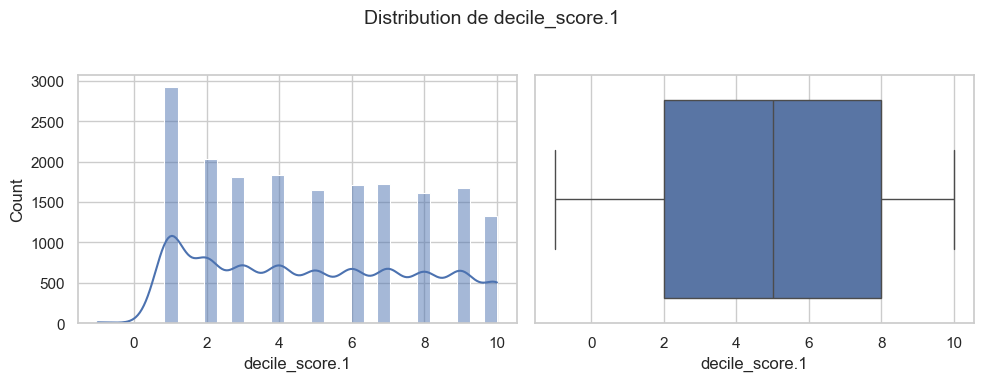

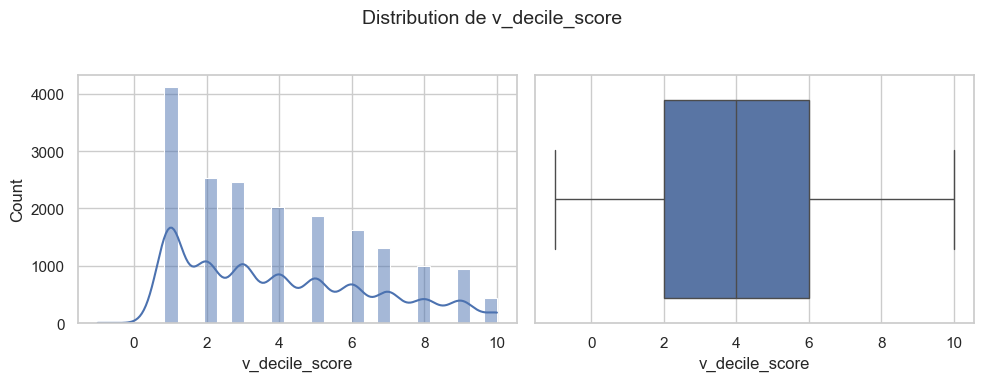

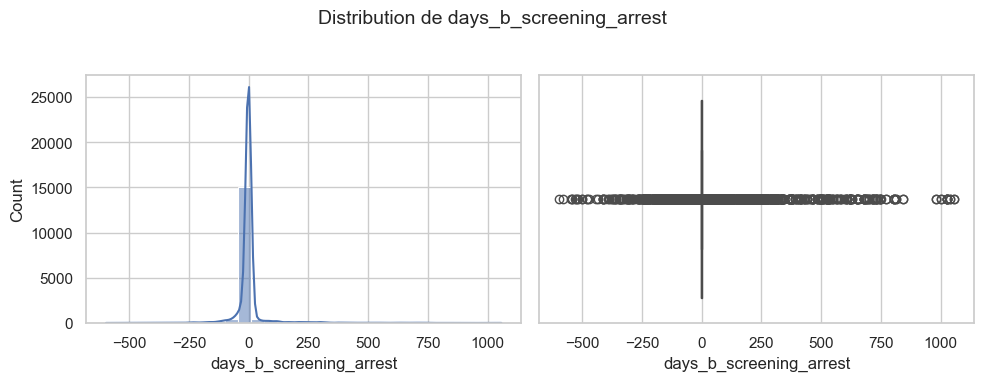

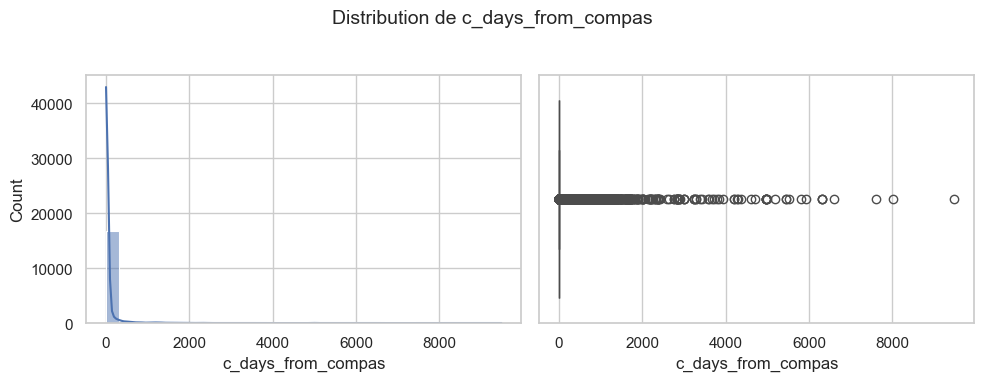

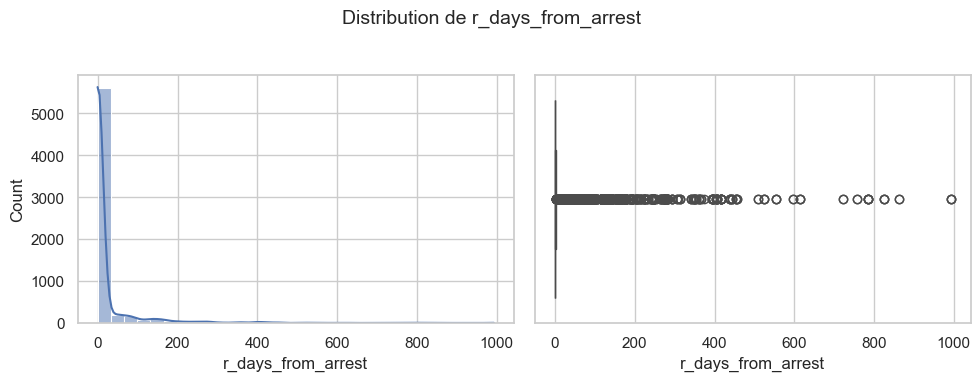

ValueError: List of boxplot statistics and `positions` values must have same the length

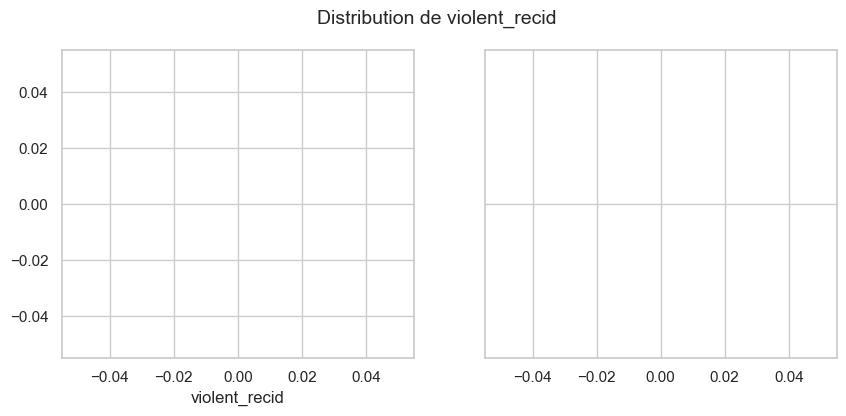

In [62]:
analyze_cv_filt(cv_filt)

In [29]:
# 2.2. Quelques statistiques

def descriptive_stats_by_type(df):
    print(f"Descriptifs pour dataframe avec {df.shape[0]} lignes et {df.shape[1]} colonnes\n")
    
    # Colonnes numériques
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(num_cols) > 0:
        print("Statistiques numériques :")
        display(df[num_cols].describe())
    
    # Colonnes catégorielles (object, category, bool)
    cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns
    for col in cat_cols:
        print(f"\nDistribution pour '{col}':")
        vc_count = df[col].value_counts(dropna=False)
        vc_freq = df[col].value_counts(dropna=False, normalize=True)
        distrib = pd.DataFrame({'count': vc_count, 'frequency': vc_freq})
        display(distrib)
    
    # Colonnes datetime
    date_cols = df.select_dtypes(include=['datetime64']).columns
    for col in date_cols:
        print(f"\nRésumé date pour '{col}':")
        print(f"Min: {df[col].min()}  |  Max: {df[col].max()}  |  NaN count: {df[col].isna().sum()}")

In [30]:
print("----- raw -----")
descriptive_stats_by_type(raw)
print("----- cv_filt -----")
descriptive_stats_by_type(cv_filt)
print("----- pp_fairml -----")
descriptive_stats_by_type(pp_fairml)

----- raw -----
Descriptifs pour dataframe avec 60843 lignes et 28 colonnes

Statistiques numériques :


Person_ID  AssessmentID       Case_ID   ScaleSet_ID  \
count  60843.000000  60843.000000  60843.000000  60843.000000   
mean   53683.206154  68061.029190  60209.128149     21.819536   
std    14363.648515   7320.208226   9638.501654      0.932614   
min      656.000000    649.000000    350.000000     17.000000   
25%    52039.000000  62582.000000  56021.000000     22.000000   
50%    57321.000000  68229.000000  61261.000000     22.000000   
75%    62748.000000  73870.000000  66554.000000     22.000000   
max    68608.000000  79678.000000  72045.000000     22.000000   

       RecSupervisionLevel      Scale_ID      RawScore   DecileScore  \
count         60843.000000  60843.000000  60843.000000  60843.000000   
mean              1.630048     11.000000      5.081457      3.571701   
std               0.944220      4.966596     10.080518      2.617854   
min               1.000000      7.000000     -4.790000     -1.000000   
25%               1.000000      7.000000     -2.090000      1.000000   
50%               1.000000      8.000000     -0.710000      3.000000   
75%               2.000000     18.000000     14.000000      5.000000   
max               4.000000     18.000000     51.000000     10.000000   

       IsCompleted  IsDeleted  
count      60843.0    60843.0  
mean           1.0        0.0  
std            0.0        0.0  
min            1.0        0.0  
25%            1.0        0.0  
50%            1.0        0.0  
75%            1.0        0.0  
max            1.0        0.0


Distribution pour 'Agency_Text':


count  frequency
Agency_Text                     
PRETRIAL        41100   0.675509
Probation       19056   0.313200
DRRD              564   0.009270
Broward County    123   0.002022


Distribution pour 'LastName':


count  frequency
LastName                           
Williams             417   0.006854
Brown                363   0.005966
Smith                345   0.005670
Johnson              333   0.005473
Jones                255   0.004191
...                  ...        ...
Garguilo               3   0.000049
MICHAEL                3   0.000049
BAZIAN                 3   0.000049
LAGUERRE               3   0.000049
velazquezmontalvo      3   0.000049

[10896 rows x 2 columns]


Distribution pour 'FirstName':


count  frequency
FirstName                    
Michael        777   0.012771
Christopher    486   0.007988
John           459   0.007544
Robert         414   0.006804
James          405   0.006656
...            ...        ...
Jearod           3   0.000049
Ganeshwar        3   0.000049
Tahir            3   0.000049
Gerinaldo        3   0.000049
Mannix           3   0.000049

[7225 rows x 2 columns]


Distribution pour 'MiddleName':


count  frequency
MiddleName                  
NaN         45219   0.743208
A             606   0.009960
L             348   0.005720
M             339   0.005572
J             330   0.005424
...           ...        ...
THEOPHILUS      3   0.000049
OLVERA          3   0.000049
Armonrajan      3   0.000049
Oswaldo         3   0.000049
ANSELMO         3   0.000049

[1871 rows x 2 columns]


Distribution pour 'Sex_Code_Text':


count  frequency
Sex_Code_Text                  
Male           47514   0.780928
Female         13329   0.219072


Distribution pour 'Ethnic_Code_Text':


count  frequency
Ethnic_Code_Text                  
African-American  27018   0.444061
Caucasian         21783   0.358020
Hispanic           8742   0.143681
Other              2592   0.042601
Asian               324   0.005325
Native American     219   0.003599
Arabic               75   0.001233
African-Am           51   0.000838
Oriental             39   0.000641


Distribution pour 'ScaleSet':


count  frequency
ScaleSet                            
Risk and Prescreen  58647   0.963907
All Scales           2196   0.036093


Distribution pour 'AssessmentReason':


count  frequency
AssessmentReason                  
Intake            60843        1.0


Distribution pour 'Language':


count  frequency
Language                  
English   60591   0.995858
Spanish     252   0.004142


Distribution pour 'LegalStatus':


count  frequency
LegalStatus                          
Pretrial             37578   0.617622
Post Sentence        18333   0.301317
Other                 4356   0.071594
Conditional Release    420   0.006903
Probation Violator     126   0.002071
Parole Violator         18   0.000296
Deferred Sentencing     12   0.000197


Distribution pour 'CustodyStatus':


count  frequency
CustodyStatus                        
Jail Inmate          30129   0.495193
Probation            22968   0.377496
Pretrial Defendant    7644   0.125635
Residential Program     66   0.001085
Parole                  21   0.000345
Prison Inmate           15   0.000247


Distribution pour 'MaritalStatus':


count  frequency
MaritalStatus                      
Single             45126   0.741679
Married             8172   0.134313
Divorced            3879   0.063754
Separated           1803   0.029634
Significant Other   1260   0.020709
Widowed              390   0.006410
Unknown              213   0.003501


Distribution pour 'RecSupervisionLevelText':


count  frequency
RecSupervisionLevelText                             
Low                                 38472   0.632316
Medium                              10476   0.172181
Medium with Override Consideration   7827   0.128643
High                                 4068   0.066861


Distribution pour 'DisplayText':


count  frequency
DisplayText                                
Risk of Violence           20281   0.333333
Risk of Recidivism         20281   0.333333
Risk of Failure to Appear  20281   0.333333


Distribution pour 'ScoreText':


count  frequency
ScoreText                  
Low        41487   0.681870
Medium     12488   0.205250
High        6823   0.112141
NaN           45   0.000740


Distribution pour 'AssessmentType':


count  frequency
AssessmentType                  
New             56139   0.922686
Copy             4704   0.077314


Résumé date pour 'DateOfBirth':
Min: 1969-01-01 00:00:00  |  Max: 2068-12-11 00:00:00  |  NaN count: 36693

Résumé date pour 'Screening_Date':
Min: 2013-01-01 00:00:00  |  Max: 2014-12-12 00:00:00  |  NaN count: 37155
----- cv_filt -----
Descriptifs pour dataframe avec 18316 lignes et 40 colonnes

Statistiques numériques :


id           age  juv_fel_count  decile_score  juv_misd_count  \
count  11001.00000  18316.000000   18316.000000  18316.000000    18316.000000   
mean    5501.00000     34.019273       0.076873      4.997052        0.098439   
std     3175.85949     11.667811       0.464272      2.937569        0.517639   
min        1.00000     18.000000       0.000000     -1.000000        0.000000   
25%     2751.00000     25.000000       0.000000      2.000000        0.000000   
50%     5501.00000     31.000000       0.000000      5.000000        0.000000   
75%     8251.00000     41.000000       0.000000      8.000000        0.000000   
max    11001.00000     96.000000      20.000000     10.000000       13.000000   

       juv_other_count  priors_count  days_b_screening_arrest  \
count     18316.000000  18316.000000             17019.000000   
mean          0.124263      3.913191                 4.302485   
std           0.524537      5.299864                81.159881   
min           0.000000      0.000000              -597.000000   
25%           0.000000      0.000000                -1.000000   
50%           0.000000      2.000000                -1.000000   
75%           0.000000      5.000000                 0.000000   
max          17.000000     43.000000              1057.000000   

       c_days_from_compas      is_recid  r_days_from_arrest  violent_recid  \
count        17449.000000  18316.000000         6359.000000            0.0   
mean            57.694596      0.414774           19.961629            NaN   
std            317.994694      0.576449           74.139695            NaN   
min              0.000000     -1.000000           -1.000000            NaN   
25%              1.000000      0.000000            0.000000            NaN   
50%              1.000000      0.000000            0.000000            NaN   
75%              2.000000      1.000000            1.000000            NaN   
max           9485.000000      1.000000          993.000000            NaN   

       is_violent_recid  decile_score.1  v_decile_score  priors_count.1  \
count      18316.000000    18316.000000    18316.000000    18316.000000   
mean           0.073105        4.997052        4.022822        3.913191   
std            0.260317        2.937569        2.614189        5.299864   
min            0.000000       -1.000000       -1.000000        0.000000   
25%            0.000000        2.000000        2.000000        0.000000   
50%            0.000000        5.000000        4.000000        2.000000   
75%            0.000000        8.000000        6.000000        5.000000   
max            1.000000       10.000000       10.000000       43.000000   

              event  
count  18316.000000  
mean       0.044715  
std        0.206683  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000


Distribution pour 'name':


count  frequency
name                                
valerie agostino       13   0.000710
brandon ross           13   0.000710
travis washington      11   0.000601
kimani ogarro          11   0.000601
eric redmond           11   0.000601
...                   ...        ...
rodney montgomery       1   0.000055
luis fernandez          1   0.000055
michelle greigg         1   0.000055
shantrina stfort        1   0.000055
barclay louisjeune      1   0.000055

[10855 rows x 2 columns]


Distribution pour 'first':


count  frequency
first                        
michael        421   0.022985
christopher    245   0.013376
anthony        233   0.012721
james          211   0.011520
john           209   0.011411
...            ...        ...
ern              1   0.000055
sebastio         1   0.000055
shantrina        1   0.000055
angelita         1   0.000055
arleen           1   0.000055

[3876 rows x 2 columns]


Distribution pour 'last':


count  frequency
last                       
williams     239   0.013049
johnson      224   0.012230
smith        209   0.011411
brown        205   0.011192
jones        168   0.009172
...          ...        ...
garrincha      1   0.000055
balmer         1   0.000055
akins          1   0.000055
sottile        1   0.000055
laporta        1   0.000055

[5635 rows x 2 columns]


Distribution pour 'sex':


count  frequency
sex                     
Male    14933   0.815298
Female   3383   0.184702


Distribution pour 'age_cat':


count  frequency
age_cat                          
25 - 45          10372   0.566281
Less than 25      4283   0.233839
Greater than 45   3661   0.199880


Distribution pour 'race':


count  frequency
race                              
African-American   9791   0.534560
Caucasian          6086   0.332278
Hispanic           1451   0.079220
Other               860   0.046953
Asian                71   0.003876
Native American      57   0.003112


Distribution pour 'c_charge_degree':


count  frequency
c_charge_degree                  
(F3)             10294   0.562022
(M1)              3681   0.200972
(F2)              1503   0.082059
(M2)              1283   0.070048
NaN                867   0.047336
(F1)               298   0.016270
(F7)               184   0.010046
(MO3)              154   0.008408
(NI0)               15   0.000819
(F6)                15   0.000819
(F5)                13   0.000710
(CO3)                6   0.000328
(X)                  1   0.000055
(CT)                 1   0.000055
(TCX)                1   0.000055


Distribution pour 'c_charge_desc':


count  frequency
c_charge_desc                                    
arrest case no charge             3085   0.168432
Battery                           2182   0.119131
Possession of Cocaine             1435   0.078347
Grand Theft in the 3rd Degree     1191   0.065025
NaN                                881   0.048100
...                                ...        ...
Sell Cannabis                        1   0.000055
Compulsory Attendance Violation      1   0.000055
Agg Battery Cause Bodily             1   0.000055
Possess Controlled Substance         1   0.000055
Insurance Fraud                      1   0.000055

[514 rows x 2 columns]


Distribution pour 'r_charge_degree':


count  frequency
r_charge_degree                  
NaN               9899   0.540456
(M1)              2922   0.159533
(M2)              2590   0.141406
(F3)              2315   0.126392
(F2)               332   0.018126
(MO3)              133   0.007261
(F1)               103   0.005623
(CO3)               10   0.000546
(F7)                 8   0.000437
(F6)                 3   0.000164
(F5)                 1   0.000055


Distribution pour 'r_charge_desc':


count  frequency
r_charge_desc                                         
NaN                                   10039   0.548100
Possess Cannabis/20 Grams Or Less       635   0.034669
Resist/Obstruct W/O Violence            561   0.030629
Driving License Suspended               538   0.029373
Petit Theft                             418   0.022822
...                                     ...        ...
Viol Injunction Protect Dom Violence      1   0.000055
D.U.I. Serious Bodily Injury              1   0.000055
No Court Susp Petit Theft                 1   0.000055
Robbery Firearm Wearing Mask              1   0.000055
Traffick Hydrocodone   4g><14g            1   0.000055

[342 rows x 2 columns]


Distribution pour 'r_jail_in':


count  frequency
r_jail_in                   
NaN         11957   0.652817
29/04/2014     29   0.001583
30/10/2014     27   0.001474
03/03/2015     24   0.001310
10/07/2014     24   0.001310
...           ...        ...
11/02/2013      1   0.000055
28/01/2016      1   0.000055
05/10/2015      1   0.000055
27/04/2015      1   0.000055
06/12/2015      1   0.000055

[973 rows x 2 columns]


Distribution pour 'vr_charge_degree':


count  frequency
vr_charge_degree                  
NaN               16977   0.926895
(M1)                550   0.030028
(F3)                374   0.020419
(F2)                276   0.015069
(F1)                 65   0.003549
(M2)                 40   0.002184
(F7)                 23   0.001256
(MO3)                 6   0.000328
(F6)                  4   0.000218
(F5)                  1   0.000055


Distribution pour 'vr_charge_desc':


count  frequency
vr_charge_desc                                   
NaN                              16977   0.926895
Battery                            529   0.028882
Battery on Law Enforc Officer       63   0.003440
Aggravated Assault W/Dead Weap      61   0.003330
Felony Battery (Dom Strang)         58   0.003167
...                                ...        ...
Discharge Firearm in Public/Res      1   0.000055
Robbery-Strong Arm W/mask            1   0.000055
Battery Spouse Or Girlfriend         1   0.000055
Murder in 2nd Degree                 1   0.000055
Vehicular Homicide                   1   0.000055

[84 rows x 2 columns]


Distribution pour 'type_of_assessment':


count  frequency
type_of_assessment                  
Risk of Recidivism  18316        1.0


Distribution pour 'score_text':


count  frequency
score_text                  
Low          8597   0.469371
Medium       5082   0.277462
High         4614   0.251911
NaN            23   0.001256


Distribution pour 'v_type_of_assessment':


count  frequency
v_type_of_assessment                  
Risk of Violence      18316        1.0


Distribution pour 'v_score_text':


count  frequency
v_score_text                  
Low           11147   0.608594
Medium         4786   0.261302
High           2377   0.129777
NaN               6   0.000328


Résumé date pour 'dob':
Min: 1919-10-14 00:00:00  |  Max: 1998-03-29 00:00:00  |  NaN count: 0

Résumé date pour 'c_jail_in':
Min: 2013-01-01 01:31:00  |  Max: 2016-03-11 10:26:00  |  NaN count: 1297

Résumé date pour 'c_jail_out':
Min: 2013-01-02 01:12:00  |  Max: 2020-01-01 00:00:00  |  NaN count: 1297

Résumé date pour 'r_offense_date':
Min: 2013-01-03 00:00:00  |  Max: 2016-03-29 00:00:00  |  NaN count: 9899

Résumé date pour 'vr_offense_date':
Min: 2013-01-28 00:00:00  |  Max: 2016-03-13 00:00:00  |  NaN count: 16977

Résumé date pour 'screening_date':
Min: 2013-01-01 00:00:00  |  Max: 2014-12-31 00:00:00  |  NaN count: 0
----- pp_fairml -----
Descriptifs pour dataframe avec 6172 lignes et 12 colonnes

Statistiques numériques :


Two_yr_Recidivism  Number_of_Priors  score_factor  \
count        6172.000000       6172.000000   6172.000000   
mean            0.455120          3.246436      0.445723   
std             0.498022          4.743770      0.497086   
min             0.000000          0.000000      0.000000   
25%             0.000000          0.000000      0.000000   
50%             0.000000          1.000000      0.000000   
75%             1.000000          4.000000      1.000000   
max             1.000000         38.000000      1.000000   

       Age_Above_FourtyFive  Age_Below_TwentyFive  African_American  \
count           6172.000000           6172.000000       6172.000000   
mean               0.209494              0.218244          0.514420   
std                0.406981              0.413087          0.499833   
min                0.000000              0.000000          0.000000   
25%                0.000000              0.000000          0.000000   
50%                0.000000              0.000000          1.000000   
75%                0.000000              0.000000          1.000000   
max                1.000000              1.000000          1.000000   

             Asian     Hispanic  Native_American        Other       Female  \
count  6172.000000  6172.000000      6172.000000  6172.000000  6172.000000   
mean      0.005023     0.082469         0.001782     0.055574     0.190376   
std       0.070698     0.275101         0.042182     0.229115     0.392629   
min       0.000000     0.000000         0.000000     0.000000     0.000000   
25%       0.000000     0.000000         0.000000     0.000000     0.000000   
50%       0.000000     0.000000         0.000000     0.000000     0.000000   
75%       0.000000     0.000000         0.000000     0.000000     0.000000   
max       1.000000     1.000000         1.000000     1.000000     1.000000   

       Misdemeanor  
count  6172.000000  
mean      0.356773  
std       0.479086  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000